In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma, norm
import optuna
from optuna.samplers import TPESampler
from optuna.samplers import RandomSampler
import pandas as pd
import pickle
import itertools

/home/tueilsy-st01/anaconda3/envs/pr-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Gamma Distribution

7.137718278286676
7
4.970848824633254
4.949747468305833


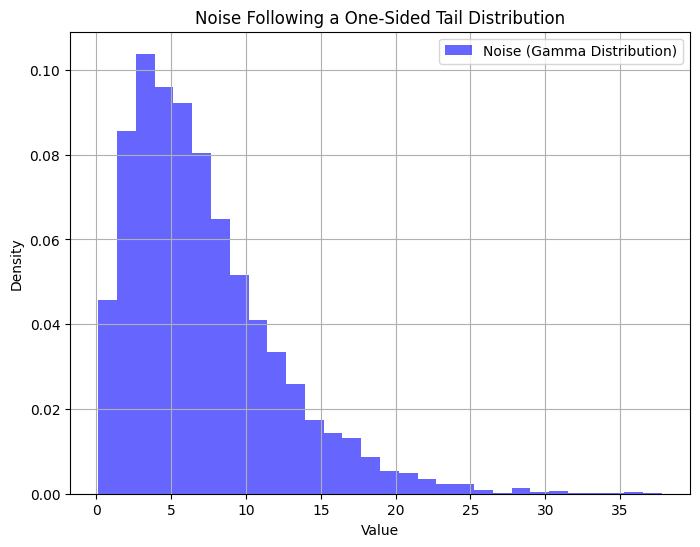

In [2]:
# Set parameters
a = 2  # Shape parameter (adjust to control tail behavior)
desired_mean = 7
scale_gamma = desired_mean / a  # Scale parameter (adjust to control spread)
ground_true_std = scale_gamma * np.sqrt(a)

# Calculate the scale parameter based on the desired mean

num_samples = 5000

# Generate noise following a gamma distribution (one-sided tail)
noise = gamma.rvs(a=a, scale=scale_gamma, size=num_samples)
print(noise.mean())
print(desired_mean)
print(noise.std())
print(ground_true_std)

# Plot the histogram of the noise
plt.figure(figsize=(8, 6))
plt.hist(noise, bins=30, density=True, alpha=0.6, color='blue', label='Noise (Gamma Distribution)')
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Noise Following a One-Sided Tail Distribution')
plt.legend()
plt.grid(True)
plt.show()

Bayesian Inference

MLE:  2.98726545527299
Posterior estimate:  2.9705353108859347


Text(0.5, 1.0, 'Estimator Comparison')

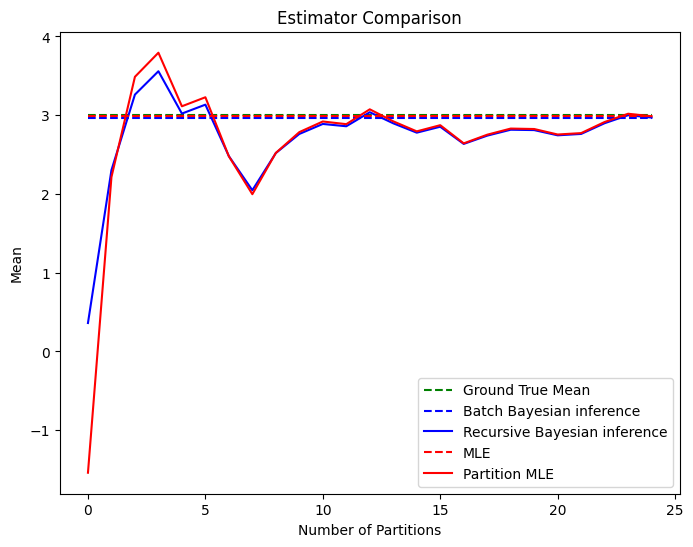

In [9]:
# ground true mean and variance for Gaussian distribution
ground_true_mean = 3
ground_true_std = 4
# number of samples
num_samples = 50
# draw samples from a Gaussian distribution
samples = norm.rvs(loc=ground_true_mean, scale=ground_true_std, size=num_samples)

# prior mean
prior_mean = 2.5
# prior std
prior_std = 3

# maximum likelihood estimate
mle = samples.mean()
print('MLE: ', mle)

# Bayesian inference
posterior_mean = (num_samples * prior_std ** 2 * mle + ground_true_std ** 2 * prior_mean) / (num_samples * prior_std ** 2 + ground_true_std ** 2)
print('Posterior estimate: ', posterior_mean)

# prior recursive Bayesian inference
# number of partitions
num_partitions = 25
# number of samples in each partition
num_samples_in_partition = num_samples/num_partitions
def Bayesian_inference(prior_mean, prior_std, mle, ground_true_std, num_samples):
    posterior_mean = (num_samples * prior_std ** 2 * mle + ground_true_std ** 2 * prior_mean) / (num_samples * prior_std ** 2 + ground_true_std ** 2)
    return posterior_mean

# posterior means
posterior_means = []
# MLEs
mles = []
for i in range(num_partitions):
    partition = samples[i * int(num_samples_in_partition): (i + 1) * int(num_samples_in_partition)]
    # if i == 0:
    #     prior_mean = partition.mean()
    #     prior_std = partition.std()
    #     continue
    posterior_means.append(Bayesian_inference(prior_mean, prior_std, partition.mean(), ground_true_std, num_samples_in_partition))
    mles.append(samples[0: (i + 1) * int(num_samples_in_partition)].mean())
    # update prior mean
    prior_mean = posterior_means[-1]
    prior_std = np.sqrt(1 / (1 / prior_std ** 2 + num_samples_in_partition / ground_true_std ** 2))

# plot posterior means
plt.figure(figsize=(8, 6))
plt.plot(np.ones(num_partitions) * ground_true_mean, 'g--', label='Ground True Mean')
# plot posterior_mean with dash line
plt.plot(np.ones(num_partitions) * posterior_mean, 'b--', label='Batch Bayesian inference')
plt.plot(posterior_means, 'b', label='Recursive Bayesian inference')
# plot MLE
plt.plot(np.ones(num_partitions) * mle, 'r--', label='MLE')
plt.plot(mles, 'r', label='Partition MLE')
# legend
plt.legend()
plt.xlabel('Number of Partitions')
plt.ylabel('Mean')
plt.title('Estimator Comparison')

Verify CVaR (Here)

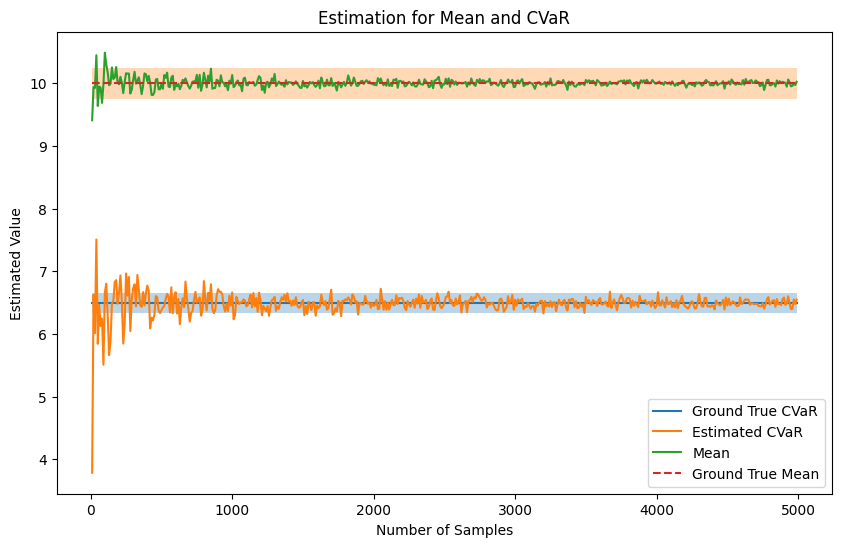

In [3]:
# cvar for normal distribution
def calculate_cvar(mu, sigma, alpha):
    # z_alpha = norm.ppf(1-alpha)
    # cvar = mu + (sigma * (norm.pdf(z_alpha) / (1-alpha)))
    # compute var
    var = norm.ppf(alpha, mu, sigma)
    # print("Var:", var)
    # compute cvar
    cvar = -alpha**-1 * norm.pdf(norm.ppf(alpha))*sigma + mu
    return cvar

def _compute_cvar(returns: np.ndarray, alpha: float = 0.2) -> float:
    """ Compute CVaR

    """
    returns = np.array(returns)
    assert returns.ndim == 1, "returns must be 1D array"
    sorted_returns = np.sort(returns)
    n = len(sorted_returns)
    VaR_idx = int(alpha * n)
    if VaR_idx == 0:
        VaR_idx = 1
    
    CVaR = sorted_returns[:VaR_idx].mean()

    return CVaR

# define a reward random variable
mu = 10
std = 2
# alhpa
alpha = 0.1
error_percentage = 0.05
ns = range(10, 5000, 10)
estimated_cvars = []
means = []
for n in ns:
    rewards = np.random.normal(mu, std, n)

    # compute quantile
    quantile = np.quantile(rewards, alpha)
    # compute CVaR
    cvar = rewards[rewards <= quantile].mean()

    # compare the CVaR computed by the closed form in calculate_cvar with the CVaR computed by the function _compute_cvar
    # print(calculate_cvar(mu, std, alpha))
    # print(_compute_cvar(rewards, alpha))
    # print(cvar)
    estimated_cvars.append(cvar)
    means.append(rewards.mean())
error_cvar = calculate_cvar(mu, std, alpha) * error_percentage
error_mean = mu * error_percentage
# plot the results
plt.figure(figsize=(10, 6))
plt.plot(ns, np.ones(len(ns)) * calculate_cvar(mu, std, alpha), label='Ground True CVaR')
plt.plot(ns, estimated_cvars, label='Estimated CVaR')
# plot error for cvar
plt.fill_between(ns, np.ones(len(ns))*calculate_cvar(mu, std, alpha)-error_cvar/2, np.ones(len(ns))*calculate_cvar(mu, std, alpha)+error_cvar/2, alpha=0.3)
plt.plot(ns, means, label='Mean')
plt.plot(ns, np.ones(len(ns)) * mu, '--', label='Ground True Mean')
# plot error for mean
plt.fill_between(ns, np.ones(len(ns))*mu-error_mean/2, np.ones(len(ns))*mu+error_mean/2, alpha=0.3)
plt.xlabel('Number of Samples')
plt.ylabel('Estimated Value')
plt.title('Estimation for Mean and CVaR')
plt.legend()
plt.show()
plt.close()

Convergence threshold

In [11]:
# times
times = 2000
# ground true mean and variance for Gaussian distribution
ground_true_means = [13]
ground_true_stds = [1]
# alhpa
alphas = [0.5, 0.1]
error_percentages = [0.0001, 0.001, 0.01]
# use mean + 3*std as the approximation upper bound
upper_bound = ground_true_mean + 3*ground_true_std

# threshold_cvar = calculate_cvar(ground_true_mean, ground_true_std, alpha) * error_percentage

# number of samples in each partition
num_samples_in_partition_mean = 4
num_samples_in_partition_cvars = [8, 12, 16]
num_samples_in_partition = 4

# Create an empty DataFrame
threshold_cvar_df = pd.DataFrame(columns=['error_percentage', 'required_n_cvar', 'cvars', 'alpha', 'error', 'num_samples_in_partition_cvar'])
threshold_mean_df = pd.DataFrame(columns=['error_percentage', 'required_n_mean', 'mles', 'error'])

required_n_mle = []
mles = []
for mean, std in zip(ground_true_means, ground_true_stds):
    for error_percentage in error_percentages:
        # thredhold
        threshold_mean = mean * error_percentage
        for _ in range(times):
            old_mle = np.inf
            samples = np.array([])
            # draw samples from a Gaussian distribution
            samples = norm.rvs(loc=mean, scale=std, size=num_samples_in_partition_mean)
            # MLE
            mle = samples.mean()
            mles.append(mle)
            while (abs(old_mle-mle) > threshold_mean):
                old_mle = mle
                # draw samples from a Gaussian distribution and append to samples
                samples = np.append(samples, norm.rvs(loc=mean, scale=std, size=num_samples_in_partition))
                mle = samples.mean()
                mles.append(mle)
            required_n_mle.append(float(len(samples)))
            # Append data to temporary DataFrame
            temp_df = pd.DataFrame({"error_percentage": [error_percentage],
                                    "required_n_mean": [float(len(samples))],
                                    "mles": [mle],
                                    "error": [abs(mle-mean)/mean]})
            # Concatenate temporary DataFrame with main DataFrame
            threshold_mean_df = pd.concat([threshold_mean_df, temp_df], ignore_index=True)

required_n_cvar = []
estimated_cvars = []
for mean, std in zip(ground_true_means, ground_true_stds):
    for alpha, error_percentage in itertools.product(alphas, error_percentages):
        cvar = calculate_cvar(mean, std, alpha)
        threshold_cvar = cvar * error_percentage
        for num_samples_in_partition_cvar in num_samples_in_partition_cvars:
            for _ in range(times):
                old_estimated_cvar = np.inf
                samples = np.array([])
                # draw samples from a Gaussian distribution
                samples = norm.rvs(loc=mean, scale=std, size=num_samples_in_partition_cvar)
                estimated_cvar = _compute_cvar(samples, alpha)
                estimated_cvars.append(estimated_cvar)
                while(abs(old_estimated_cvar-estimated_cvar) > threshold_cvar):
                    old_estimated_cvar = estimated_cvar
                    # draw samples from a Gaussian distribution and append to samples
                    samples = np.append(samples, norm.rvs(loc=mean, scale=std, size=num_samples_in_partition_cvar))
                    estimated_cvar = _compute_cvar(samples, alpha)
                    estimated_cvars.append(estimated_cvar)          
                required_n_cvar.append(float(len(samples)))
                # Append data to temporary DataFrame
                temp_df = pd.DataFrame({"error_percentage": [error_percentage],
                                        "required_n_cvar": [float(len(samples))],
                                        "cvars": [estimated_cvar],
                                        "alpha": [alpha],
                                        "error": [abs(estimated_cvar-cvar)/cvar],
                                        "num_samples_in_partition_cvar": [num_samples_in_partition_cvar]})
                # Concatenate temporary DataFrame with main DataFrame
                threshold_cvar_df = pd.concat([threshold_cvar_df, temp_df], ignore_index=True)


# print(f'Required number of samples for MLE: {np.mean(required_n_mle)} +- {np.std(required_n_mle)}')
# print(f'Required number of samples for CVaR: {np.mean(required_n_cvar)} +- {np.std(required_n_cvar)}')
# print('Ground true mean: ', ground_true_mean)
# print('Ground true CVaR: ', calculate_cvar(ground_true_mean, ground_true_std, alpha))
# print(f'Estimated mean: {np.mean(mles)} +- {np.std(mles)}')
# print(f'Estimated CVaR: {np.mean(estimated_cvars)} +- {np.std(estimated_cvars)}')


In [12]:
# group by error percentage
threshold_cvar_df.groupby(['error_percentage', 'alpha', 'num_samples_in_partition_cvar']).agg(['mean', 'std'])

required_n_cvar  \
                                                                mean   
error_percentage alpha num_samples_in_partition_cvar                   
0.0001           0.1   8                                      50.764   
                       12                                    407.412   
                       16                                    504.384   
                 0.5   8                                     211.508   
                       12                                    285.330   
                       16                                    357.704   
0.0010           0.1   8                                      40.804   
                       12                                    131.358   
                       16                                    161.224   
                 0.5   8                                      67.640   
                       12                                     93.066   
                       16                                    116.168   
0.0100           0.1   8                                      24.728   
                       12                                     41.994   
                       16                                     55.952   
                 0.5   8                                      24.840   
                       12                                     34.998   
                       16                                     43.952   

                                                                      cvars  \
                                                             std       mean   
error_percentage alpha num_samples_in_partition_cvar                          
0.0001           0.1   8                               53.927269  11.232166   
                       12                             211.116924  11.249899   
                       16                             257.364261  11.253019   
                 0.5   8                              106.350840  12.206505   
                       12                             140.869930  12.203104   
                       16                             185.107160  12.208440   
0.0010           0.1   8                               35.433958  11.238487   
                       12                              64.613213  11.272465   
                       16                              75.376380  11.261585   
                 0.5   8                               32.184535  12.219568   
                       12                              40.205073  12.215110   
                       16                              51.627827  12.205886   
0.0100           0.1   8                               12.286965  11.267070   
                       12                              16.666459  11.297689   
                       16                              20.375998  11.273674   
                 0.5   8                                8.148595  12.229887   
                       12                              10.792879  12.225666   
                       16                              12.519907  12.225967   

                                                                   error  \
                                                           std      mean   
error_percentage alpha num_samples_in_partition_cvar                       
0.0001           0.1   8                              0.432569  0.028383   
                       12                             0.117691  0.007756   
                       16                             0.107154  0.006942   
                 0.5   8                              0.095800  0.005779   
                       12                             0.083702  0.005208   
                       16                             0.076788  0.004720   
0.0010           0.1   8                              0.432891  0.028867   
                       12                             0.197888  0.013548   
                       16                   

In [13]:
threshold_mean_df.groupby(['error_percentage']).agg(['mean', 'std'])

required_n_mean                  mles               error  \
                            mean        std       mean       std      mean   
error_percentage                                                             
0.0001                   111.302  56.655642  12.998952  0.111077  0.006512   
0.0010                    35.678  16.817066  12.998566  0.196081  0.011560   
0.0100                    13.054   4.450055  13.011663  0.282079  0.017153   

                            
                       std  
error_percentage            
0.0001            0.005530  
0.0010            0.009686  
0.0100            0.013313

Non-Convex Function

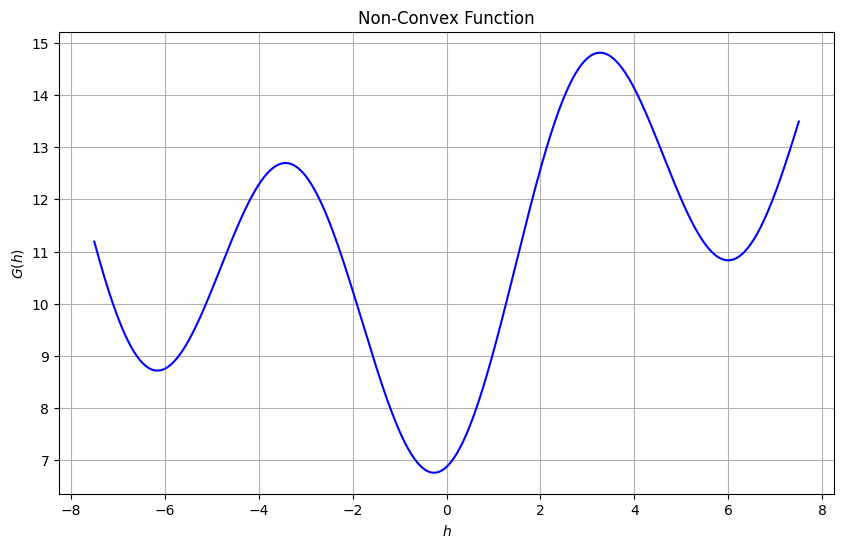

In [4]:
# Define the non-convex function
def non_convex_function(x):
    return (4 * np.sin((x - 3) / 3) + 5 * np.cos(x - 3) + 20) / 1.7


# Generate x values
x = np.linspace(-7.5, 7.5, 500)

# Plot the original and noisy functions
plt.figure(figsize=(10, 6))
plt.plot(x, non_convex_function(x), color='blue')
# plot optimum

plt.xlabel(r'$h$')
plt.ylabel(r'$G(h)$')
plt.title('Non-Convex Function')
plt.grid(True)

plt.savefig('fig/prelininaries/non-convex function.pdf', format="pdf")

Sanity Check for HPO on Non-Convex Function

In [134]:
# spec
samplers = ["TPESampler", "RandomSampler"]
strategies = ["naive_single_run"]
strategy_names = {"naive_single_run": "Returned h",}
budgets = ['num_of_trials']
# specify bin boundaries
bins = np.linspace(-7.5, 7.5, 80)
times = 100
trials = [200, 350, 500]
# trials = [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]

def sanity_objective(trial):
    G = 0
    h = trial.suggest_float("h", -7.5, 7.5)
    G = non_convex_function(h)
    with open("num_of_eval.pickle", "rb") as fin:
        num_of_eval = pickle.load(fin)
    num_of_eval += 1
    with open("num_of_eval.pickle", "wb") as fout:
        pickle.dump(num_of_eval, fout)
    return G
    

optuna.logging.set_verbosity(optuna.logging.WARNING)
# Create an empty DataFrame
sanity_df = pd.DataFrame(columns=['Sampler', 'G', 'h', 'Strategy', 'num_of_eval', 'num_of_trials'])

for trial in trials:
    for sampler in samplers:
        for s in strategies:
            for _ in range(times):
                num_of_eval = 0
                with open("num_of_eval.pickle", "wb") as fout:
                    pickle.dump(num_of_eval, fout)
                if sampler == "TPESampler":
                    study = optuna.create_study(sampler=TPESampler(n_startup_trials=5), direction="maximize")
                elif sampler == "RandomSampler":
                    study = optuna.create_study(sampler=RandomSampler(), direction="maximize")

                study.optimize(lambda trial: sanity_objective(trial), n_trials=trial)
                best_params = study.best_params
                with open("num_of_eval.pickle", "rb") as fin:
                    num_of_eval = pickle.load(fin)
                # Append data to temporary DataFrame
                temp_df = pd.DataFrame({"Sampler": [sampler],
                                        "G": [non_convex_function(best_params["h"])],
                                        "h": [best_params["h"]],  
                                        "Strategy": [s],
                                        "num_of_eval": [num_of_eval],
                                        "num_of_trials": [len(study.trials)]})

                # Concatenate temporary DataFrame with main DataFrame
                sanity_df = pd.concat([sanity_df, temp_df], ignore_index=True)


# # pickle the sanity_df
# with open("sanity_df.pickle", "wb") as fout:
#     pickle.dump(sanity_df, fout)

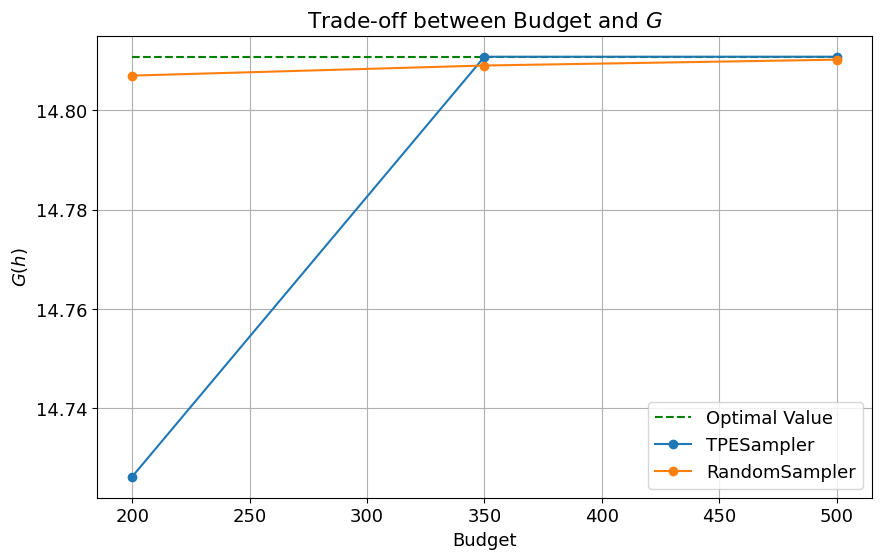

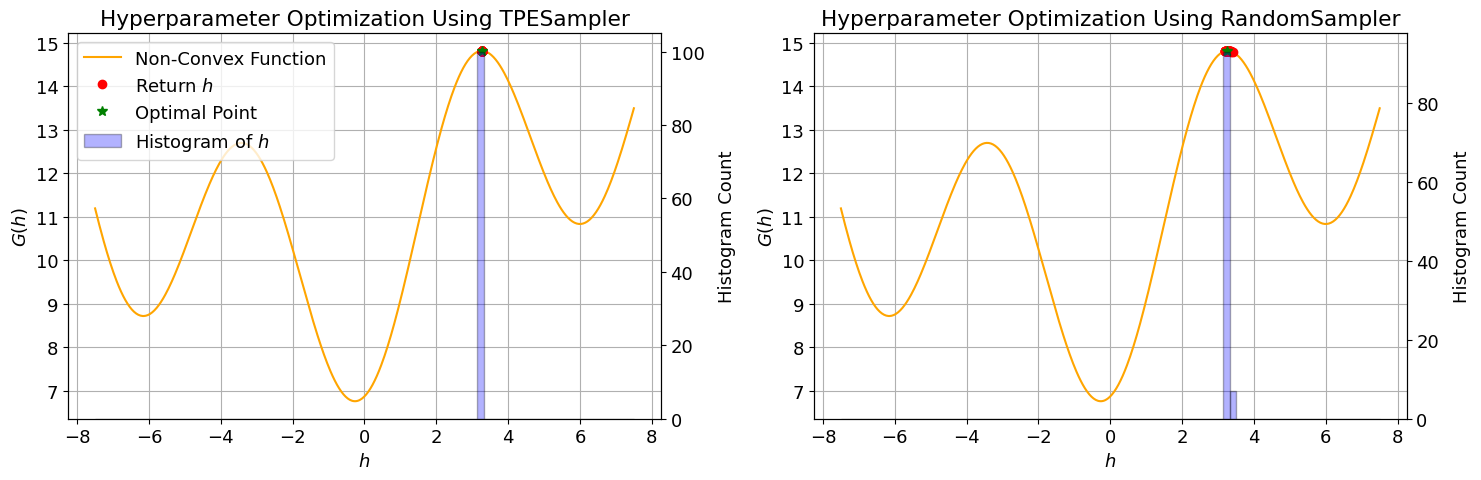

In [138]:
# load the sanity_df
with open("sanity_df.pickle", "rb") as fin:
    sanity_df = pickle.load(fin)


for budget in budgets:
        plt.rcParams.update({'font.size': 13})
        plt.figure(figsize=(10, 6))
        # plot optimal line
        plt.plot(sanity_df.loc[sanity_df['Sampler'] == sampler].loc[sanity_df['Strategy'] == strategies[0]].groupby(budget)[budget].mean(),
                np.max(non_convex_function(x)) * np.ones(len(sanity_df.loc[sanity_df['Sampler'] == sampler].loc[sanity_df['Strategy'] == strategies[0]].groupby(budget)[budget].mean())),
                '--', label='Optimal Value', color='green')
        for sampler in samplers:
                # plot data points for each strategy
                plt.plot(sanity_df.loc[sanity_df['Sampler'] == sampler].loc[sanity_df['Strategy'] == strategies[0]].groupby(budget)[budget].mean(), 
                        sanity_df.loc[sanity_df['Sampler'] == sampler].loc[sanity_df['Strategy'] == strategies[0]].groupby(budget)['G'].mean(),
                        'o-', label=sampler)

                plt.xlabel("Budget")
                plt.ylabel(r'$G(h)$')
                plt.title(r'Trade-off between Budget and $G$')
                plt.legend()
                plt.grid(True)
        plt.savefig('fig/prelininaries/tradeoff between budget and G.pdf', format="pdf")
        plt.show()
        plt.close()

trial_to_describe = trials[1]

# Generate x values
x = np.linspace(-7.5, 7.5, 500)

# Calculate the original non-convex function values
original_function_values = non_convex_function(x)

# Calculate the number of subplots needed
num_samplers = len(samplers)
num_strategies = len(strategies)
num_plots = num_samplers * num_strategies

# Calculate the number of rows and columns for subplots
num_rows = (num_plots + 2) // 3
num_cols = min(num_plots, 3)

# Create subplots
plt.rcParams.update({'font.size': 13})
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))

# Flatten axes if needed
if num_rows > 1:
    axes = axes.flatten()

# Loop through samplers and strategies
for idx, (sampler, strategy) in enumerate(itertools.product(samplers, strategies)):
    ax = axes[idx]  # Get the current subplot axis

    ax2 = ax.twinx()

    ax.plot(x, original_function_values, label='Non-Convex Function', color='orange')

    # plot data points for each strategy
    ax.plot(sanity_df.loc[sanity_df['num_of_trials'] == trial_to_describe].loc[sanity_df['Sampler'] == sampler].loc[sanity_df['Strategy'] == strategy]['h'], 
             sanity_df.loc[sanity_df['num_of_trials'] == trial_to_describe].loc[sanity_df['Sampler'] == sampler].loc[sanity_df['Strategy'] == strategy]['G'],
             'o', label=r'Return $h$', color='red')
    
    # plot the histogram on the right side (secondary y-axis)
    ax2.hist(sanity_df.loc[sanity_df['num_of_trials'] == trial_to_describe].loc[sanity_df['Sampler'] == sampler].loc[sanity_df['Strategy'] == strategy]['h'],
             bins=bins, edgecolor='black', color='blue', alpha=0.3, label=r'Histogram of $h$')
    ax2.set_ylabel('Histogram Count', labelpad=10)  # Right y-axis label with labelpad to adjust position

    # plot the optimal point from original_function_values in green on the left y-axis
    ax.plot(x[np.argmax(original_function_values)], np.max(original_function_values), 
            '*', markersize=7, label="Optimal Point", color='green')
    
    ax.set_xlabel(r'$h$')
    ax.set_ylabel('Non-Convex Function')  # Left y-axis label
    ax.set_ylabel(r'$G(h)$')  # Right y-axis label
    ax.set_title('Hyperparameter Optimization Using ' + sampler)

    # Combine legends from both axes
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    if idx == 0:
        ax.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    ax.grid(True)

# Adjust layout and display the plots
plt.tight_layout()
plt.savefig('fig/prelininaries/hpo for non-convex fn.pdf', format="pdf")
plt.show()
plt.close()

Different Noise Mode in Non-Convex Function (Here)

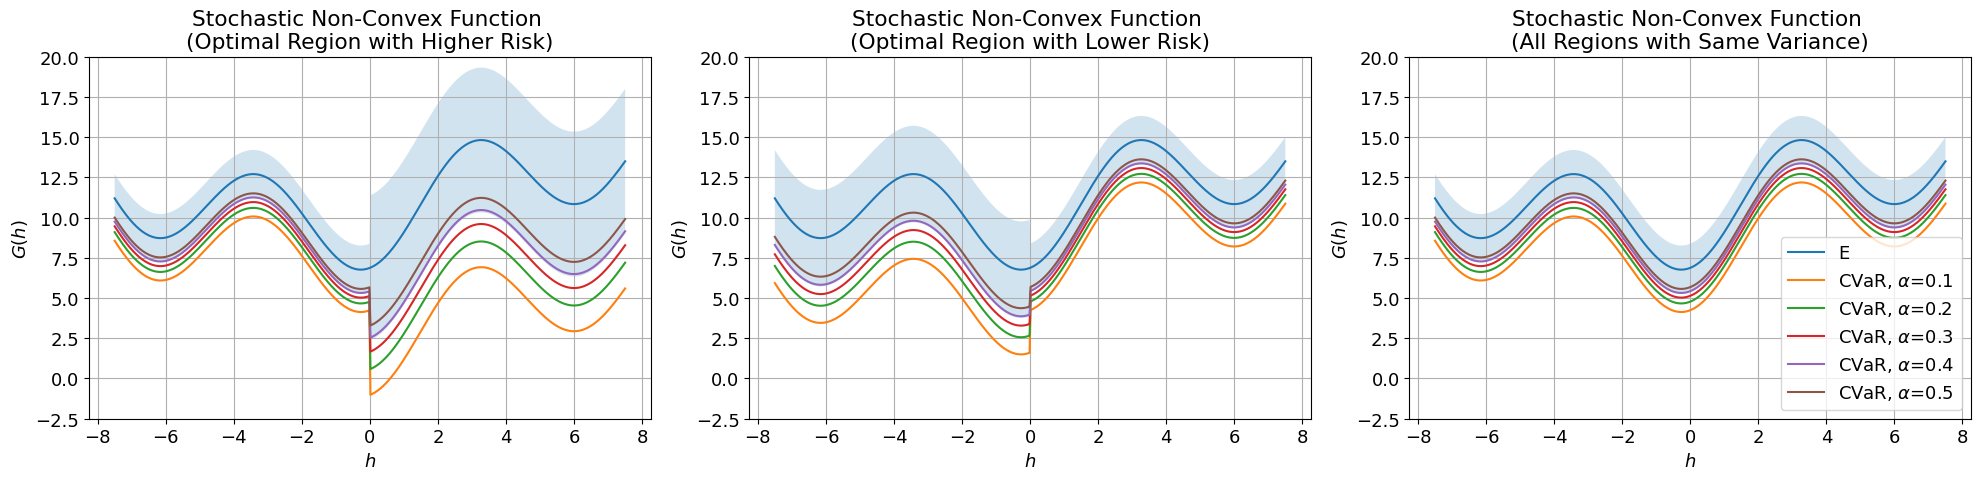

In [5]:
# Define the noisy function values based on the provided code
noise_function_modes = ["h_e_h_v_l_e_h_v", 
                        # "h_e_h_v_l_e_l_v", 
                        "h_e_l_v_l_e_h_v", 
                        "h_e_l_v_l_e_l_v"]
# human readable
function_modes = {"h_e_h_v_l_e_h_v": "Optimal Region with Higher Risk",
                #   "h_e_h_v_l_e_l_v": "Sub-optimal Region with Lower Risk",
                  "h_e_l_v_l_e_h_v": "Optimal Region with Lower Risk",
                  "h_e_l_v_l_e_l_v": "All Regions with Same Variance"}
# noise level
noise_levels = [
                "Low", 
                # "High"
                ]
alphas = [0.1, 0.2, 0.3, 0.4, 0.5]
def non_convex_noisy_function(x, noise_function_mode, noise_level):
    # Set parameters for the gamma distribution noise
    use_gamma = False
    if noise_level == "Low":
        a_gamma = 2
        std_normal = 1.5
    elif noise_level == "High":
        a_gamma = 3
        std_normal = 3
    
    desired_mean = non_convex_function(x)

    # Calculate the scale parameter based on the desired mean
    scale_gamma = desired_mean / a_gamma

    # Set parameters for the normal distribution noise
    mean_normal = 0

    if noise_function_mode == "h_e_l_v_l_e_h_v": # Optimal Region with Dramatically Lower Risk
        if x < 0:
            # Generate noise following a gamma distribution (one-sided tail)
            if use_gamma:
                gamma_noise = gamma.rvs(a=a_gamma, scale=scale_gamma, size=1)
                noise = gamma_noise
                noisy_function_values = noise
                std = scale_gamma * np.sqrt(a_gamma)
            else:
                std_normal = 2*std_normal
                normal_noise = norm.rvs(loc=mean_normal, scale=std_normal, size=1)
                noise = normal_noise
                noisy_function_values = non_convex_function(x) + noise
                std = std_normal
        else:
            normal_noise = norm.rvs(loc=mean_normal, scale=std_normal, size=1)
            noise = normal_noise
            noisy_function_values = non_convex_function(x) + noise
            std = std_normal
    elif noise_function_mode == "h_e_l_v_l_e_l_v": # All Regions with Similar Risk
        normal_noise = norm.rvs(loc=mean_normal, scale=std_normal, size=1)
        noise = normal_noise
        noisy_function_values = non_convex_function(x) + noise
        std = std_normal
    elif noise_function_mode == "h_e_h_v_l_e_h_v": # Optimal Region with Slightly Higher Risk
        # Generate noise following a gamma distribution (one-sided tail)
        if use_gamma:
            gamma_noise = gamma.rvs(a=a_gamma, scale=scale_gamma, size=1)
            noise = gamma_noise
            noisy_function_values = noise
            std = scale_gamma * np.sqrt(a_gamma)
        else:
            if x > 0:
                std_normal = 3*std_normal
                normal_noise = norm.rvs(loc=mean_normal, scale=std_normal, size=1)
                noise = normal_noise
                noisy_function_values = non_convex_function(x) + noise
                std = std_normal
            else:
                normal_noise = norm.rvs(loc=mean_normal, scale=std_normal, size=1)
                noise = normal_noise
                noisy_function_values = non_convex_function(x) + noise
                std = std_normal
    elif noise_function_mode == "h_e_h_v_l_e_l_v": # Sub-optimal Region with Lower Risk
        if x > 0:
            if use_gamma:
                # Generate noise following a gamma distribution (one-sided tail)
                gamma_noise = gamma.rvs(a=a_gamma, scale=scale_gamma, size=1)
                noise = gamma_noise
                noisy_function_values = noise
                std = scale_gamma * np.sqrt(a_gamma)
            else:
                std_normal = 3*std_normal
                normal_noise = norm.rvs(loc=mean_normal, scale=std_normal, size=1)
                noise = normal_noise
                noisy_function_values = non_convex_function(x) + noise
                std = std_normal
        else:
            normal_noise = norm.rvs(loc=mean_normal, scale=std_normal, size=1)
            noise = normal_noise
            noisy_function_values = non_convex_function(x) + noise
            std = std_normal
    
    return noisy_function_values, std


# Generate x values
x = np.linspace(-7.5, 7.5, 500)

# Calculate the original non-convex function values
original_function_values = non_convex_function(x)

# Create subplots with 3 columns
num_cols = 3
num_rows = (len(noise_levels) * len(noise_function_modes) + num_cols - 1) // num_cols
plt.rcParams.update({'font.size': 13})
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5*num_rows))

# Flatten axes if needed
if num_rows > 1:
    axes = axes.flatten()

plot_counter = 0  # Counter for subplot

for noise_level in noise_levels:
    for noise_function_mode in noise_function_modes:
        ax = axes[plot_counter]  # Get the current subplot axis

        # Calculate the noisy function values and stds
        noisy_function_values = np.array([])
        stds = np.array([])
        for xi in x:
            v, std = non_convex_noisy_function(xi, noise_function_mode, noise_level)
            noisy_function_values = np.append(noisy_function_values, v)
            stds = np.append(stds, std)

        # Plot the functions
        ax.plot(x, original_function_values, label=f'E')
        ax.fill_between(x, original_function_values - stds, original_function_values + stds, alpha=0.2)
        for alpha in alphas:
            cvar = calculate_cvar(original_function_values, stds, alpha)
            ax.plot(x, cvar, label=f'CVaR, ' + r'${\alpha} $' + f'={alpha}')
        ax.set_xlabel(r'$h$')
        ax.set_ylabel(r'$G(h)$')
        # set y limit
        ax.set_ylim(-2.5, 20)
        ax.set_title(f'Stochastic Non-Convex Function \n({function_modes[noise_function_mode]})')
        ax.grid(True)

        # # plot the optimal point from original_function_values in green
        # ax.plot(x[np.argmax(cvar)], original_function_values[np.argmax(cvar)], 
        #         '*', markersize=12, label="Optimal Point", color='green')

        plot_counter += 1

        # Break if all subplots are done
        if plot_counter >= len(noise_levels) * len(noise_function_modes):
            ax.legend()
            break

# Adjust layout and display the plots
plt.tight_layout()
plt.savefig('fig/prelininaries/CVaR in different alpha.pdf', format="pdf")
plt.show()

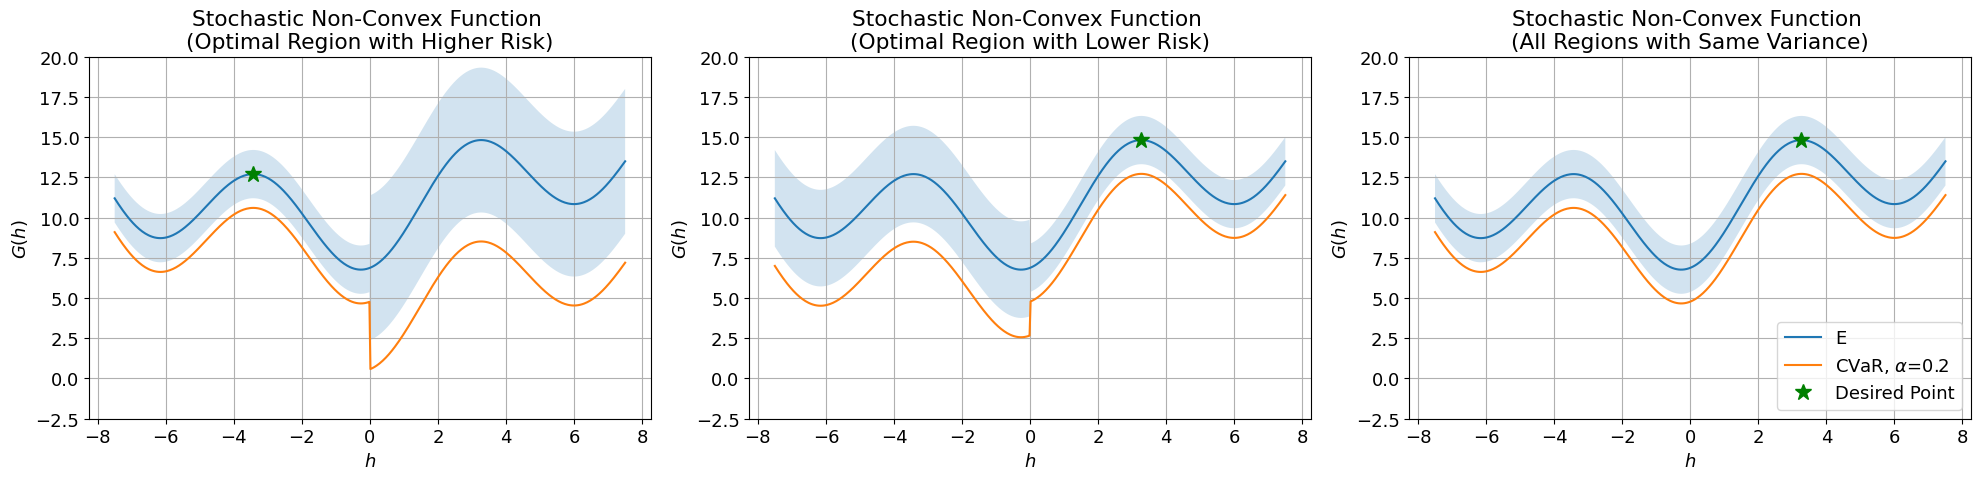

In [10]:
alphas = [0.2]

# Generate x values
x = np.linspace(-7.5, 7.5, 500)

# Calculate the original non-convex function values
original_function_values = non_convex_function(x)

# Create subplots with 3 columns
num_cols = 3
num_rows = (len(noise_levels) * len(noise_function_modes) + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5*num_rows))

# Flatten axes if needed
if num_rows > 1:
    axes = axes.flatten()

plot_counter = 0  # Counter for subplot

for noise_level in noise_levels:
    for noise_function_mode in noise_function_modes:
        ax = axes[plot_counter]  # Get the current subplot axis

        # Calculate the noisy function values and stds
        noisy_function_values = np.array([])
        stds = np.array([])
        for xi in x:
            v, std = non_convex_noisy_function(xi, noise_function_mode, noise_level)
            noisy_function_values = np.append(noisy_function_values, v)
            stds = np.append(stds, std)

        # Plot the functions
        ax.plot(x, original_function_values, label=f'E')
        ax.fill_between(x, original_function_values - stds, original_function_values + stds, alpha=0.2)
        for alpha in alphas:
            cvar = calculate_cvar(original_function_values, stds, alpha)
            ax.plot(x, cvar, label=f'CVaR, ' + r'${\alpha} $' + f'={alpha}')
        ax.set_xlabel(r'$h$')
        ax.set_ylabel(r'$G(h)$')
        # set y limit
        ax.set_ylim(-2.5, 20)
        ax.set_title(f'Stochastic Non-Convex Function \n({function_modes[noise_function_mode]})')
        ax.grid(True)

        # plot the optimal point from original_function_values in green
        ax.plot(x[np.argmax(cvar)], original_function_values[np.argmax(cvar)], 
                '*', markersize=12, label="Desired Point", color='green')

        plot_counter += 1

        # Break if all subplots are done
        if plot_counter >= len(noise_function_modes):
            ax.legend(loc='lower right')
            break

# Adjust layout and display the plots
plt.tight_layout()
plt.savefig('fig/experiments/non-convex function with noise.pdf', format="pdf")
plt.show()

In [6]:

# spec
noise_function_modes = ["h_e_h_v_l_e_h_v", 
                        # "h_e_h_v_l_e_l_v", 
                        "h_e_l_v_l_e_h_v", 
                        "h_e_l_v_l_e_l_v"]
samplers = ["TPESampler", "RandomSampler"]
strategies = ["naive_single_run",
              "naive_multiple_runs",
              "multiple_runs_w/_CVaR",
              "dynamics_runs_w/_CVaR",
              "dynamics_runs_w/o_CVaR"]
budgets = ['num_of_trials', 'num_of_eval']
# noise level
noise_levels = [
                "Low", 
                # "High"
                ]
times = 100
trials = [350]
# trials = [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
alphas = [0.1, 0.5]
warm_trials = 1
percentage_cvar = 0.001
percentage_mean = 0.01
thresholds_cvar = 15 * percentage_cvar
thresholds_mean = 15 * percentage_mean


# number of samples in each partition
num_samples_in_partition_mean = 4
num_samples_in_partition_cvars = 8

# define trials to make resource allocation fair
single_run_trial = 4200
multiple_runs_trial = int(4200/num_samples_in_partition_mean)
multiple_runs_cvar_trial = int(4200/num_samples_in_partition_cvars)


def objective(trial, s, noise_function_mode, noise_level, threshold, repitition, alpha):
    G = 0
    if s == "naive_single_run":
        h = trial.suggest_float("h", -7.5, 7.5)
        G, _ = non_convex_noisy_function(h, noise_function_mode, noise_level)
        with open("num_of_eval.pickle", "rb") as fin:
            num_of_eval = pickle.load(fin)
        num_of_eval += 1
        with open("num_of_eval.pickle", "wb") as fout:
            pickle.dump(num_of_eval, fout)
    elif s == "naive_multiple_runs":
        f = []
        h = trial.suggest_float("h", -7.5, 7.5)
        for _ in range(repitition):
            v, _ = non_convex_noisy_function(h, noise_function_mode, noise_level)
            f.append(v)
            with open("num_of_eval.pickle", "rb") as fin:
                num_of_eval = pickle.load(fin)
            num_of_eval += 1
            with open("num_of_eval.pickle", "wb") as fout:
                pickle.dump(num_of_eval, fout)
        G = np.mean(f)
    elif s == "multiple_runs_w/_CVaR":
        f = []
        h = trial.suggest_float("h", -7.5, 7.5)
        for _ in range(repitition):
            v, _ = non_convex_noisy_function(h, noise_function_mode, noise_level)
            f.append(v[0])
            with open("num_of_eval.pickle", "rb") as fin:
                num_of_eval = pickle.load(fin)
            num_of_eval += 1
            with open("num_of_eval.pickle", "wb") as fout:
                pickle.dump(num_of_eval, fout)
        G = _compute_cvar(f, alpha)
    elif s == "dynamics_runs_w/_CVaR":
        increase_runs = True
        first_iteration = True
        f = []
        h = trial.suggest_float("h", -7.5, 7.5)
        while increase_runs:
            increase_runs = False
            if first_iteration:
                Gs = np.inf
            for _ in range(repitition):
                v, _ = non_convex_noisy_function(h, noise_function_mode, noise_level)
                f.append(v[0])
                with open("num_of_eval.pickle", "rb") as fin:
                    num_of_eval = pickle.load(fin)
                num_of_eval += 1
                with open("num_of_eval.pickle", "wb") as fout:
                    pickle.dump(num_of_eval, fout)
            Gss = _compute_cvar(np.array(f), alpha)

            # if the current objective is better than the best objective, trigger more runs to avoid maximization bias
            if warm_trials < len(study.trials):
                if Gss > study.best_value or first_iteration == False:
                    if abs(Gs - Gss) > threshold:
                        increase_runs = True
                        first_iteration = False
                        Gs = Gss
                    else:
                        increase_runs = False
        G = Gss
    elif s == "dynamics_runs_w/o_CVaR":
        increase_runs = True
        first_iteration = True
        f = []
        h = trial.suggest_float("h", -7.5, 7.5)
        while increase_runs:
            increase_runs = False
            if first_iteration:
                Gs = np.inf
            for _ in range(repitition):
                v, _ = non_convex_noisy_function(h, noise_function_mode, noise_level)
                f.append(v[0])
                with open("num_of_eval.pickle", "rb") as fin:
                    num_of_eval = pickle.load(fin)
                num_of_eval += 1
                with open("num_of_eval.pickle", "wb") as fout:
                    pickle.dump(num_of_eval, fout)
            Gss = np.mean(f)

            # if the current objective is better than the best objective, trigger more runs to avoid maximization bias
            if warm_trials < len(study.trials):
                if Gss > study.best_value or first_iteration == False:
                    if abs(Gs - Gss) > threshold:
                        increase_runs = True
                        first_iteration = False
                        Gs = Gss
                    else:
                        increase_runs = False
        G = Gss
    return G

Same trials for all strategies

In [ ]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
# Create an empty DataFrame
df = pd.DataFrame(columns=['Sampler', 'G', 'std', 'h', 'Strategy', 'num_of_eval', 'num_of_trials', 'alpha', 'error_percentage', 'noise_function_mode'])

for noise_level in noise_levels:
    for noise_function_mode in noise_function_modes:
        for trial in trials:
            for sampler in samplers:
                for s in strategies:
                    for _ in range(times):
                        num_of_eval = 0
                        with open("num_of_eval.pickle", "wb") as fout:
                            pickle.dump(num_of_eval, fout)
                        if s == "naive_single_run":
                            if sampler == "TPESampler":
                                study = optuna.create_study(sampler=TPESampler(n_startup_trials=5), direction="maximize")
                            elif sampler == "RandomSampler":
                                study = optuna.create_study(sampler=RandomSampler(), direction="maximize")
                            alpha = 1
                            error_percentage = 0
                            threshold = 0
                            repitition = 0
                            study.optimize(lambda trial: objective(trial, s, noise_function_mode, noise_level, threshold, repitition, alpha), n_trials=trial)
                            best_params = study.best_params
                            with open("num_of_eval.pickle", "rb") as fin:
                                num_of_eval = pickle.load(fin)
                            _, std = non_convex_noisy_function(best_params["h"], noise_function_mode, noise_level)
                            # Append data to temporary DataFrame
                            temp_df = pd.DataFrame({"Sampler": [sampler],
                                                    "G": [non_convex_function(best_params["h"])],
                                                    'std': [std],
                                                    "h": [best_params["h"]],  
                                                    "Strategy": [s],
                                                    "num_of_eval": [num_of_eval],
                                                    "num_of_trials": [len(study.trials)],
                                                    "alpha": [alpha],
                                                    "error_percentage": [error_percentage],
                                                    "noise_function_mode": [noise_function_mode]})

                            # Concatenate temporary DataFrame with main DataFrame
                            df = pd.concat([df, temp_df], ignore_index=True)
                        elif s == "naive_multiple_runs":
                            if sampler == "TPESampler":
                                study = optuna.create_study(sampler=TPESampler(n_startup_trials=5), direction="maximize")
                            elif sampler == "RandomSampler":
                                study = optuna.create_study(sampler=RandomSampler(), direction="maximize")
                            alpha = 1
                            error_percentage = 0
                            threshold = 0
                            repitition = num_samples_in_partition_mean
                            study.optimize(lambda trial: objective(trial, s, noise_function_mode, noise_level, threshold, repitition, alpha), n_trials=trial)
                            best_params = study.best_params
                            with open("num_of_eval.pickle", "rb") as fin:
                                num_of_eval = pickle.load(fin)
                            _, std = non_convex_noisy_function(best_params["h"], noise_function_mode, noise_level)
                            # Append data to temporary DataFrame
                            temp_df = pd.DataFrame({"Sampler": [sampler],
                                                    "G": [non_convex_function(best_params["h"])],
                                                    'std': [std],
                                                    "h": [best_params["h"]],  
                                                    "Strategy": [s],
                                                    "num_of_eval": [num_of_eval],
                                                    "num_of_trials": [len(study.trials)],
                                                    "alpha": [alpha],
                                                    "error_percentage": [error_percentage],
                                                    "noise_function_mode": [noise_function_mode]})

                            # Concatenate temporary DataFrame with main DataFrame
                            df = pd.concat([df, temp_df], ignore_index=True)
                        elif s == "multiple_runs_w/_CVaR":
                            error_percentage = 0
                            threshold = 0
                            repitition = num_samples_in_partition_cvars
                            for alpha in alphas:
                                if sampler == "TPESampler":
                                    study = optuna.create_study(sampler=TPESampler(n_startup_trials=5), direction="maximize")
                                elif sampler == "RandomSampler":
                                    study = optuna.create_study(sampler=RandomSampler(), direction="maximize")
                                study.optimize(lambda trial: objective(trial, s, noise_function_mode, noise_level, threshold, repitition, alpha), n_trials=trial)
                                best_params = study.best_params
                                with open("num_of_eval.pickle", "rb") as fin:
                                    num_of_eval = pickle.load(fin)
                                _, std = non_convex_noisy_function(best_params["h"], noise_function_mode, noise_level)
                                # Append data to temporary DataFrame
                                temp_df = pd.DataFrame({"Sampler": [sampler],
                                                        "G": [non_convex_function(best_params["h"])],
                                                        'std': [std],
                                                        "h": [best_params["h"]],  
                                                        "Strategy": [s],
                                                        "num_of_eval": [num_of_eval],
                                                        "num_of_trials": [len(study.trials)],
                                                        "alpha": [alpha],
                                                        "error_percentage": [error_percentage],
                                                        "noise_function_mode": [noise_function_mode]})

                                # Concatenate temporary DataFrame with main DataFrame
                                df = pd.concat([df, temp_df], ignore_index=True)
                        elif s == "dynamics_runs_w/_CVaR":
                            error_percentage = percentage_cvar
                            threshold = thresholds_cvar
                            repitition = num_samples_in_partition_cvars
                            for alpha in alphas:
                                if sampler == "TPESampler":
                                    study = optuna.create_study(sampler=TPESampler(n_startup_trials=5), direction="maximize")
                                elif sampler == "RandomSampler":
                                    study = optuna.create_study(sampler=RandomSampler(), direction="maximize")
                                study.optimize(lambda trial: objective(trial, s, noise_function_mode, noise_level, threshold, repitition, alpha), n_trials=trial)
                                best_params = study.best_params
                                with open("num_of_eval.pickle", "rb") as fin:
                                    num_of_eval = pickle.load(fin)
                                _, std = non_convex_noisy_function(best_params["h"], noise_function_mode, noise_level)
                                # Append data to temporary DataFrame
                                temp_df = pd.DataFrame({"Sampler": [sampler],
                                                        "G": [non_convex_function(best_params["h"])],
                                                        'std': [std],
                                                        "h": [best_params["h"]],  
                                                        "Strategy": [s],
                                                        "num_of_eval": [num_of_eval],
                                                        "num_of_trials": [len(study.trials)],
                                                        "alpha": [alpha],
                                                        "error_percentage": [error_percentage],
                                                        "noise_function_mode": [noise_function_mode]})

                                # Concatenate temporary DataFrame with main DataFrame
                                df = pd.concat([df, temp_df], ignore_index=True)
                        elif s == "dynamics_runs_w/o_CVaR":
                            if sampler == "TPESampler":
                                study = optuna.create_study(sampler=TPESampler(n_startup_trials=5), direction="maximize")
                            elif sampler == "RandomSampler":
                                study = optuna.create_study(sampler=RandomSampler(), direction="maximize")
                            alpha = 1
                            error_percentage = percentage_mean
                            threshold = thresholds_mean
                            repitition = num_samples_in_partition_mean
                            study.optimize(lambda trial: objective(trial, s, noise_function_mode, noise_level, threshold, repitition, alpha), n_trials=trial)
                            best_params = study.best_params
                            with open("num_of_eval.pickle", "rb") as fin:
                                num_of_eval = pickle.load(fin)
                            _, std = non_convex_noisy_function(best_params["h"], noise_function_mode, noise_level)
                            # Append data to temporary DataFrame
                            temp_df = pd.DataFrame({"Sampler": [sampler],
                                                    "G": [non_convex_function(best_params["h"])],
                                                    'std': [std],
                                                    "h": [best_params["h"]],  
                                                    "Strategy": [s],
                                                    "num_of_eval": [num_of_eval],
                                                    "num_of_trials": [len(study.trials)],
                                                    "alpha": [alpha],
                                                    "error_percentage": [error_percentage],
                                                    "noise_function_mode": [noise_function_mode]})

                            # Concatenate temporary DataFrame with main DataFrame
                            df = pd.concat([df, temp_df], ignore_index=True)
                        

In [17]:
# # pickle the dataframe
# with open('toy_examples_df.pickle', 'wb') as fout:
#     pickle.dump(df, fout)

In [11]:
# load the dataframe
with open('toy_examples_df.pickle', 'rb') as fin:
    df = pickle.load(fin)

In [24]:
# print num_of_eval for each strategy
df.groupby('Strategy')['num_of_eval'].describe()


count  unique   top  freq
Strategy                                         
dynamics_runs_w/_CVaR    1200     705  4176     7
dynamics_runs_w/o_CVaR    600     176  1512    13
multiple_runs_w/_CVaR    1200       2  2800   600
naive_multiple_runs       600       1  1400   600
naive_single_run          600       1   350   600

Fairer resource allocation

In [29]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
# Create an empty DataFrame
df = pd.DataFrame(columns=['Sampler', 'G', 'std', 'h', 'Strategy', 'num_of_eval', 'num_of_trials', 'alpha', 'error_percentage', 'noise_function_mode'])

for noise_level in noise_levels:
    for noise_function_mode in noise_function_modes:
        for sampler in samplers:
            for s in strategies:
                for _ in range(times):
                    num_of_eval = 0
                    with open("num_of_eval.pickle", "wb") as fout:
                        pickle.dump(num_of_eval, fout)
                    if s == "naive_single_run":
                        if sampler == "TPESampler":
                            study = optuna.create_study(sampler=TPESampler(n_startup_trials=5), direction="maximize")
                        elif sampler == "RandomSampler":
                            study = optuna.create_study(sampler=RandomSampler(), direction="maximize")
                        alpha = 1
                        error_percentage = 0
                        threshold = 0
                        repitition = 0
                        trial = single_run_trial
                        study.optimize(lambda trial: objective(trial, s, noise_function_mode, noise_level, threshold, repitition, alpha), n_trials=trial)
                        best_params = study.best_params
                        with open("num_of_eval.pickle", "rb") as fin:
                            num_of_eval = pickle.load(fin)
                        _, std = non_convex_noisy_function(best_params["h"], noise_function_mode, noise_level)
                        # Append data to temporary DataFrame
                        temp_df = pd.DataFrame({"Sampler": [sampler],
                                                "G": [non_convex_function(best_params["h"])],
                                                'std': [std],
                                                "h": [best_params["h"]],  
                                                "Strategy": [s],
                                                "num_of_eval": [num_of_eval],
                                                "num_of_trials": [len(study.trials)],
                                                "alpha": [alpha],
                                                "error_percentage": [error_percentage],
                                                "noise_function_mode": [noise_function_mode]})

                        # Concatenate temporary DataFrame with main DataFrame
                        df = pd.concat([df, temp_df], ignore_index=True)
                    elif s == "naive_multiple_runs":
                        if sampler == "TPESampler":
                            study = optuna.create_study(sampler=TPESampler(n_startup_trials=5), direction="maximize")
                        elif sampler == "RandomSampler":
                            study = optuna.create_study(sampler=RandomSampler(), direction="maximize")
                        alpha = 1
                        error_percentage = 0
                        threshold = 0
                        repitition = num_samples_in_partition_mean
                        trial = multiple_runs_trial
                        study.optimize(lambda trial: objective(trial, s, noise_function_mode, noise_level, threshold, repitition, alpha), n_trials=trial)
                        best_params = study.best_params
                        with open("num_of_eval.pickle", "rb") as fin:
                            num_of_eval = pickle.load(fin)
                        _, std = non_convex_noisy_function(best_params["h"], noise_function_mode, noise_level)
                        # Append data to temporary DataFrame
                        temp_df = pd.DataFrame({"Sampler": [sampler],
                                                "G": [non_convex_function(best_params["h"])],
                                                'std': [std],
                                                "h": [best_params["h"]],  
                                                "Strategy": [s],
                                                "num_of_eval": [num_of_eval],
                                                "num_of_trials": [len(study.trials)],
                                                "alpha": [alpha],
                                                "error_percentage": [error_percentage],
                                                "noise_function_mode": [noise_function_mode]})

                        # Concatenate temporary DataFrame with main DataFrame
                        df = pd.concat([df, temp_df], ignore_index=True)
                    elif s == "multiple_runs_w/_CVaR":
                        error_percentage = 0
                        threshold = 0
                        repitition = num_samples_in_partition_cvars
                        for alpha in alphas:
                            if sampler == "TPESampler":
                                study = optuna.create_study(sampler=TPESampler(n_startup_trials=5), direction="maximize")
                            elif sampler == "RandomSampler":
                                study = optuna.create_study(sampler=RandomSampler(), direction="maximize")
                            trial = multiple_runs_cvar_trial
                            study.optimize(lambda trial: objective(trial, s, noise_function_mode, noise_level, threshold, repitition, alpha), n_trials=trial)
                            best_params = study.best_params
                            with open("num_of_eval.pickle", "rb") as fin:
                                num_of_eval = pickle.load(fin)
                            _, std = non_convex_noisy_function(best_params["h"], noise_function_mode, noise_level)
                            # Append data to temporary DataFrame
                            temp_df = pd.DataFrame({"Sampler": [sampler],
                                                    "G": [non_convex_function(best_params["h"])],
                                                    'std': [std],
                                                    "h": [best_params["h"]],  
                                                    "Strategy": [s],
                                                    "num_of_eval": [num_of_eval],
                                                    "num_of_trials": [len(study.trials)],
                                                    "alpha": [alpha],
                                                    "error_percentage": [error_percentage],
                                                    "noise_function_mode": [noise_function_mode]})

                            # Concatenate temporary DataFrame with main DataFrame
                            df = pd.concat([df, temp_df], ignore_index=True)
                    elif s == "dynamics_runs_w/_CVaR":
                        error_percentage = percentage_cvar
                        threshold = thresholds_cvar
                        repitition = num_samples_in_partition_cvars
                        for alpha in alphas:
                            if sampler == "TPESampler":
                                study = optuna.create_study(sampler=TPESampler(n_startup_trials=5), direction="maximize")
                            elif sampler == "RandomSampler":
                                study = optuna.create_study(sampler=RandomSampler(), direction="maximize")
                            trial = trials[0]
                            study.optimize(lambda trial: objective(trial, s, noise_function_mode, noise_level, threshold, repitition, alpha), n_trials=trial)
                            best_params = study.best_params
                            with open("num_of_eval.pickle", "rb") as fin:
                                num_of_eval = pickle.load(fin)
                            _, std = non_convex_noisy_function(best_params["h"], noise_function_mode, noise_level)
                            # Append data to temporary DataFrame
                            temp_df = pd.DataFrame({"Sampler": [sampler],
                                                    "G": [non_convex_function(best_params["h"])],
                                                    'std': [std],
                                                    "h": [best_params["h"]],  
                                                    "Strategy": [s],
                                                    "num_of_eval": [num_of_eval],
                                                    "num_of_trials": [len(study.trials)],
                                                    "alpha": [alpha],
                                                    "error_percentage": [error_percentage],
                                                    "noise_function_mode": [noise_function_mode]})

                            # Concatenate temporary DataFrame with main DataFrame
                            df = pd.concat([df, temp_df], ignore_index=True)
                    elif s == "dynamics_runs_w/o_CVaR":
                        if sampler == "TPESampler":
                            study = optuna.create_study(sampler=TPESampler(n_startup_trials=5), direction="maximize")
                        elif sampler == "RandomSampler":
                            study = optuna.create_study(sampler=RandomSampler(), direction="maximize")
                        alpha = 1
                        error_percentage = percentage_mean
                        threshold = thresholds_mean
                        repitition = num_samples_in_partition_mean
                        trial = trials[0]
                        study.optimize(lambda trial: objective(trial, s, noise_function_mode, noise_level, threshold, repitition, alpha), n_trials=trial)
                        best_params = study.best_params
                        with open("num_of_eval.pickle", "rb") as fin:
                            num_of_eval = pickle.load(fin)
                        _, std = non_convex_noisy_function(best_params["h"], noise_function_mode, noise_level)
                        # Append data to temporary DataFrame
                        temp_df = pd.DataFrame({"Sampler": [sampler],
                                                "G": [non_convex_function(best_params["h"])],
                                                'std': [std],
                                                "h": [best_params["h"]],  
                                                "Strategy": [s],
                                                "num_of_eval": [num_of_eval],
                                                "num_of_trials": [len(study.trials)],
                                                "alpha": [alpha],
                                                "error_percentage": [error_percentage],
                                                "noise_function_mode": [noise_function_mode]})

                        # Concatenate temporary DataFrame with main DataFrame
                        df = pd.concat([df, temp_df], ignore_index=True) 

In [32]:
# # pickle the dataframe
# with open('toy_examples_df_fair.pickle', 'wb') as fout:
#     pickle.dump(df, fout)

In [35]:
# print num_of_eval for each strategy
df.groupby('Strategy')['num_of_eval'].describe()

In [18]:
# load the dataframe
with open('toy_examples_df_fair.pickle', 'rb') as fin:
    df = pickle.load(fin)

samplers = ["TPESampler", "RandomSampler"]
strategies = ["naive_single_run",
              "naive_multiple_runs",
              "multiple_runs_w/_CVaR",
              "dynamics_runs_w/_CVaR",
              "dynamics_runs_w/o_CVaR"]
strategy_names = {"naive_single_run": "naive_single_run",
                  "naive_multiple_runs": "naive_multiple_runs",
                  "multiple_runs_w/_CVaR": "multiple_runs_w/_CVaR",
                  "dynamics_runs_w/_CVaR": "AMRA_w/_CVaR",
                  "dynamics_runs_w/o_CVaR": "AMRA_w/o_CVaR"}
budgets = ['num_of_trials', 'num_of_eval']
# visualize the results
for noise_level in noise_levels:
        for noise_function_mode in noise_function_modes:
                for budget in budgets:
                        for sampler in samplers:
                                plt.figure(figsize=(10, 6))
                                # plot data points for each strategy
                                plt.plot(df.loc[df['noise_levels'] == noise_level].loc[df['noise_function_modes'] == noise_function_mode].loc[df['Sampler'] == sampler].loc[df['Strategy'] == strategies[0]].groupby(budget)[budget].mean(), 
                                        df.loc[df['noise_levels'] == noise_level].loc[df['noise_function_modes'] == noise_function_mode].loc[df['Sampler'] == sampler].loc[df['Strategy'] == strategies[0]].groupby(budget)['G'].mean(),
                                        'o-', label=strategy_names[strategies[0]], color='red')
                                plt.fill_between(df.loc[df['noise_levels'] == noise_level].loc[df['noise_function_modes'] == noise_function_mode].loc[df['Sampler'] == sampler].loc[df['Strategy'] == strategies[0]].groupby(budget)[budget].mean(),
                                                df.loc[df['noise_levels'] == noise_level].loc[df['noise_function_modes'] == noise_function_mode].loc[df['Sampler'] == sampler].loc[df['Strategy'] == strategies[0]].groupby(budget)['G'].mean() - 0.02*df.loc[df['noise_levels'] == noise_level].loc[df['noise_function_modes'] == noise_function_mode].loc[df['Sampler'] == sampler].loc[df['Strategy'] == strategies[0]].groupby(budget)['std'].mean(),
                                                df.loc[df['noise_levels'] == noise_level].loc[df['noise_function_modes'] == noise_function_mode].loc[df['Sampler'] == sampler].loc[df['Strategy'] == strategies[0]].groupby(budget)['G'].mean() + 0.02*df.loc[df['noise_levels'] == noise_level].loc[df['noise_function_modes'] == noise_function_mode].loc[df['Sampler'] == sampler].loc[df['Strategy'] == strategies[0]].groupby(budget)['std'].mean(),
                                                alpha=0.1, color='red')
                                plt.plot(df.loc[df['noise_levels'] == noise_level].loc[df['noise_function_modes'] == noise_function_mode].loc[df['Sampler'] == sampler].loc[df['Strategy'] == strategies[1]].groupby(budget)[budget].mean(),
                                        df.loc[df['noise_levels'] == noise_level].loc[df['noise_function_modes'] == noise_function_mode].loc[df['Sampler'] == sampler].loc[df['Strategy'] == strategies[1]].groupby(budget)['G'].mean(),
                                        'o-', label=strategy_names[strategies[1]], color='purple')
                                plt.fill_between(df.loc[df['noise_levels'] == noise_level].loc[df['noise_function_modes'] == noise_function_mode].loc[df['Sampler'] == sampler].loc[df['Strategy'] == strategies[1]].groupby(budget)[budget].mean(),
                                                df.loc[df['noise_levels'] == noise_level].loc[df['noise_function_modes'] == noise_function_mode].loc[df['Sampler'] == sampler].loc[df['Strategy'] == strategies[1]].groupby(budget)['G'].mean() - 0.02*df.loc[df['noise_levels'] == noise_level].loc[df['noise_function_modes'] == noise_function_mode].loc[df['Sampler'] == sampler].loc[df['Strategy'] == strategies[1]].groupby(budget)['std'].mean(),
                                                df.loc[df['noise_levels'] == noise_level].loc[df['noise_function_modes'] == noise_function_mode].loc[df['Sampler'] == sampler].loc[df['Strategy'] == strategies[1]].groupby(budget)['G'].mean() + 0.02*df.loc[df['noise_levels'] == noise_level].loc[df['noise_function_modes'] == noise_function_mode].loc[df['Sampler'] == sampler].loc[df['Strategy'] == strategies[1]].groupby(budget)['std'].mean(),
                                                alpha=0.1, color='purple')
                                plt.plot(df.loc[df['noise_levels'] == noise_level].loc[df['noise_function_modes'] == noise_function_mode].loc[df['Sampler'] == sampler].loc[df['Strategy'] == strategies[2]].groupby(budget)[budget].mean(),
                                        df.loc[df['noise_levels'] == noise_level].loc[df['noise_function_modes'] == noise_function_mode].loc[df['Sampler'] == sampler].loc[df['Strategy'] == strategies[2]].groupby(budget)['G'].mean(),
                                        'o-', label=strategy_names[strategies[2]], color='green')
                                plt.fill_between(df.loc[df['noise_levels'] == noise_level].loc[df['noise_function_modes'] == noise_function_mode].loc[df['Sampler'] == sampler].loc[df['Strategy'] == strategies[2]].groupby(budget)[budget].mean(),
                                                df.loc[df['noise_levels'] == noise_level].loc[df['noise_function_modes'] == noise_function_mode].loc[df['Sampler'] == sampler].loc[df['Strategy'] == strategies[2]].groupby(budget)['G'].mean() - 0.02*df.loc[df['noise_levels'] == noise_level].loc[df['noise_function_modes'] == noise_function_mode].loc[df['Sampler'] == sampler].loc[df['Strategy'] == strategies[2]].groupby(budget)['std'].mean(),
                                                df.loc[df['noise_levels'] == noise_level].loc[df['noise_function_modes'] == noise_function_mode].loc[df['Sampler'] == sampler].loc[df['Strategy'] == strategies[2]].groupby(budget)['G'].mean() + 0.02*df.loc[df['noise_levels'] == noise_level].loc[df['noise_function_modes'] == noise_function_mode].loc[df['Sampler'] == sampler].loc[df['Strategy'] == strategies[2]].groupby(budget)['std'].mean(),
                                                alpha=0.1, color='green')
                                plt.plot(df.loc[df['noise_levels'] == noise_level].loc[df['noise_function_modes'] == noise_function_mode].loc[df['Sampler'] == sampler].loc[df['Strategy'] == strategies[3]].groupby(budget)[budget].mean(),
                                        df.loc[df['noise_levels'] == noise_level].loc[df['noise_function_modes'] == noise_function_mode].loc[df['Sampler'] == sampler].loc[df['Strategy'] == strategies[3]].groupby(budget)['G'].mean(),
                                        'o-', label=strategy_names[strategies[3]], color='black')
                                plt.fill_between(df.loc[df['noise_levels'] == noise_level].loc[df['noise_function_modes'] == noise_function_mode].loc[df['Sampler'] == sampler].loc[df['Strategy'] == strategies[3]].groupby(budget)[budget].mean(),
                                                df.loc[df['noise_levels'] == noise_level].loc[df['noise_function_modes'] == noise_function_mode].loc[df['Sampler'] == sampler].loc[df['Strategy'] == strategies[3]].groupby(budget)['G'].mean() - 0.02*df.loc[df['noise_levels'] == noise_level].loc[df['noise_function_modes'] == noise_function_mode].loc[df['Sampler'] == sampler].loc[df['Strategy'] == strategies[3]].groupby(budget)['std'].mean(),
                                                df.loc[df['noise_levels'] == noise_level].loc[df['noise_function_modes'] == noise_function_mode].loc[df['Sampler'] == sampler].loc[df['Strategy'] == strategies[3]].groupby(budget)['G'].mean() + 0.02*df.loc[df['noise_levels'] == noise_level].loc[df['noise_function_modes'] == noise_function_mode].loc[df['Sampler'] == sampler].loc[df['Strategy'] == strategies[3]].groupby(budget)['std'].mean(),
                                                alpha=0.1, color='black')
                                plt.plot(df.loc[df['noise_levels'] == noise_level].loc[df['noise_function_modes'] == noise_function_mode].loc[df['Sampler'] == sampler].loc[df['Strategy'] == strategies[4]].groupby(budget)[budget].mean(),
                                        df.loc[df['noise_levels'] == noise_level].loc[df['noise_function_modes'] == noise_function_mode].loc[df['Sampler'] == sampler].loc[df['Strategy'] == strategies[4]].groupby(budget)['G'].mean(),
                                        'o-', label=strategy_names[strategies[4]], color='brown')
                                plt.fill_between(df.loc[df['noise_levels'] == noise_level].loc[df['noise_function_modes'] == noise_function_mode].loc[df['Sampler'] == sampler].loc[df['Strategy'] == strategies[4]].groupby(budget)[budget].mean(),
                                                df.loc[df['noise_levels'] == noise_level].loc[df['noise_function_modes'] == noise_function_mode].loc[df['Sampler'] == sampler].loc[df['Strategy'] == strategies[4]].groupby(budget)['G'].mean() - 0.02*df.loc[df['noise_levels'] == noise_level].loc[df['noise_function_modes'] == noise_function_mode].loc[df['Sampler'] == sampler].loc[df['Strategy'] == strategies[4]].groupby(budget)['std'].mean(),
                                                df.loc[df['noise_levels'] == noise_level].loc[df['noise_function_modes'] == noise_function_mode].loc[df['Sampler'] == sampler].loc[df['Strategy'] == strategies[4]].groupby(budget)['G'].mean() + 0.02*df.loc[df['noise_levels'] == noise_level].loc[df['noise_function_modes'] == noise_function_mode].loc[df['Sampler'] == sampler].loc[df['Strategy'] == strategies[4]].groupby(budget)['std'].mean(),
                                                alpha=0.1, color='brown')
                                plt.xlabel(budget)
                                plt.ylabel('G(h)')
                                plt.title('Trade-off between Budget and G Using ' + sampler + f' with Noise Level {noise_level}' + f' ({function_modes[noise_function_mode]})')
                                plt.legend()
                                plt.grid(True)
                                plt.show()
                                plt.close()

Fair Comparisons (Here)

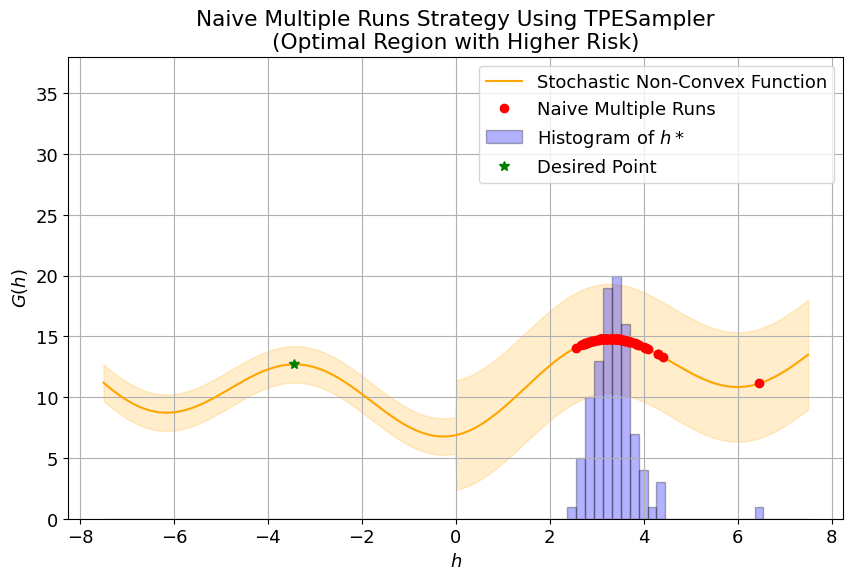

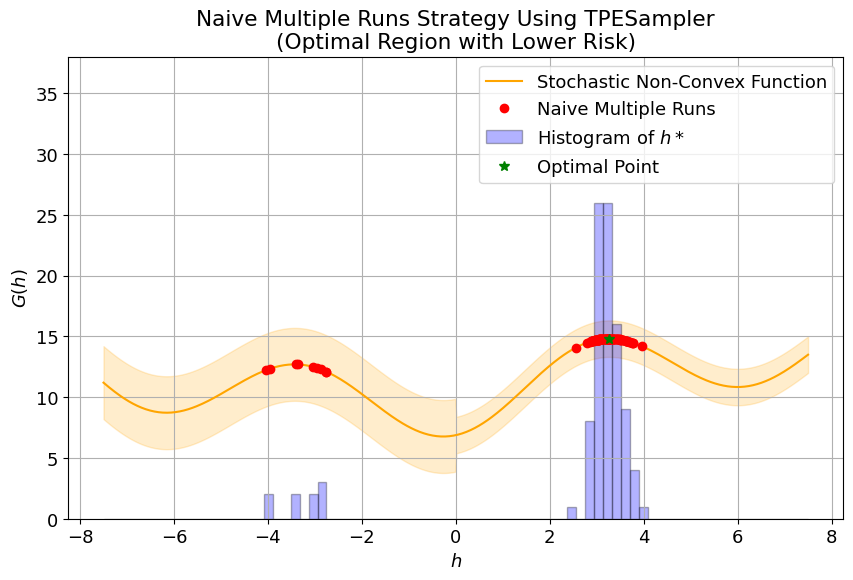

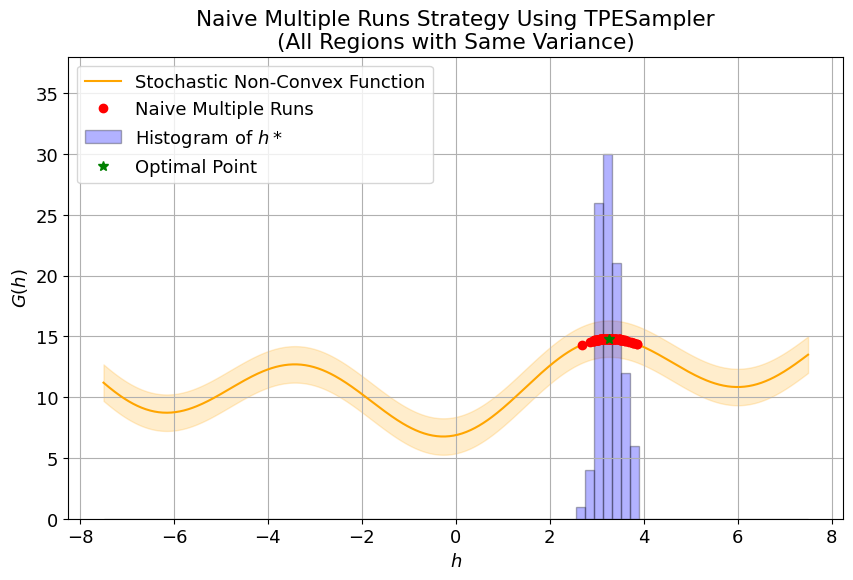

In [34]:
# load the dataframe
with open('toy_examples_df_fair.pickle', 'rb') as fin:
    df = pickle.load(fin)
alphas = [0.1, 0.5]
samplers = ["TPESampler"]
# strategies = ["naive_single_run",
#               "naive_multiple_runs",
#               "dynamics_runs_w/o_CVaR",
#               "multiple_runs_w/_CVaR",
#               "dynamics_runs_w/_CVaR"
#               ]
strategy_names = {"naive_single_run": "Naive Single Run",
                  "naive_multiple_runs": "Naive Multiple Runs",
                  "multiple_runs_w/_CVaR": "Multiple Runs with CVaR",
                  "dynamics_runs_w/_CVaR": "AMRA with CVaR",
                  "dynamics_runs_w/o_CVaR": "AMRA with Expectations"}
percentage_cvar = 0.001
percentage_mean = 0.01
thresholds_cvar = 15 * percentage_cvar
thresholds_mean = 15 * percentage_mean
bins = np.linspace(-7.5, 7.5, 80)
# visualize the results
for noise_level in noise_levels:
    for noise_function_mode in noise_function_modes:
        for sampler in samplers:
            idx = 0
            for strategy in strategies:
                if strategy != "multiple_runs_w/_CVaR" and strategy != "dynamics_runs_w/_CVaR":
                    pass
                #     if idx == 0:
                #         fig, axs = plt.subplots(1, 3, figsize=(10 * 3, 6))
                #     if idx == 3:
                #         plt.show()
                #         plt.close()              
                if strategy == "multiple_runs_w/_CVaR":
                        
                    # plt.scatter(x, noisy_function_values, alpha=0.5, color='orange')
                    # plot data points for each strategy
                    num_cols = len(alphas)  # Number of columns for subplots
                    # fig, axs = plt.subplots(1, num_cols, figsize=(10 * num_cols, 6))
                    for idx, alpha in enumerate(alphas):
                        # ax = axs[idx]
                        plt.figure(figsize=(10, 6))
                        plt.rcParams.update({'font.size': 13})
                        # Calculate the noisy function values
                        noisy_function_values = np.array([])
                        stds = np.array([]) 
                        for xi in x:
                                # append the noisy function values to the array
                                v, std = non_convex_noisy_function(xi, noise_function_mode, noise_level)
                                noisy_function_values = np.append(noisy_function_values, v)
                                stds = np.append(stds, std) 
                                
                        plt.plot(x, original_function_values, label='Stochastic Non-Convex Function', color='orange')
                        # plot std
                        plt.fill_between(x, original_function_values - stds, original_function_values + stds, alpha=0.2, color='orange')
                        plt.plot(df.loc[df['noise_function_mode'] == noise_function_mode].loc[df['Sampler'] == sampler].loc[df['Strategy'] == strategy].loc[df['alpha'] == alpha]['h'], 
                                df.loc[df['noise_function_mode'] == noise_function_mode].loc[df['Sampler'] == sampler].loc[df['Strategy'] == strategy].loc[df['alpha'] == alpha]['G'],
                                'o', label=strategy_names[strategy], color='red')
                        plt.hist(df.loc[df['noise_function_mode'] == noise_function_mode].loc[df['Sampler'] == sampler].loc[df['Strategy'] == strategy].loc[df['alpha'] == alpha]['h'],
                                bins=bins, edgecolor='black', color='blue', alpha=0.3, label=r'Histogram of $h*$')
                        if noise_function_mode == 'h_e_h_v_l_e_h_v':
                                # plot the optimal point for x < 0 
                                plt.plot(x[np.argmax(original_function_values[:int(len(original_function_values)/2)])], 
                                        np.max(original_function_values[:int(len(original_function_values)/2)]), 
                                        '*', markersize=7, label="Desired Point", color='green')
                        else:
                                # plot the optimal point from original_function_values in green
                                plt.plot(x[np.argmax(original_function_values)], np.max(original_function_values), 
                                        '*', markersize=7, label="Optimal Point", color='green')
                        cvar = calculate_cvar(original_function_values, stds, alpha)
                        plt.plot(x, cvar, label=f'CVaR, ' + r'${\alpha} $' + f'={alpha}')
                        plt.xlabel(r'$h$')
                        plt.ylabel(r'$G(h)$')
                        plt.ylim(0, 38)
                        plt.title(f'{strategy_names[strategy]} Strategy Using ' + sampler + f'\n({function_modes[noise_function_mode]})')
                        plt.legend()
                        plt.grid(True)
                        plt.savefig(f'fig/experiments/{strategy_names[strategy]} ({function_modes[noise_function_mode]}, Alpha={alpha}).pdf', format="pdf")
                        plt.show()
                        plt.close()
                    # plt.show()
                    # plt.close()
                elif strategy == "dynamics_runs_w/_CVaR":
                    num_cols = len(alphas)  # Number of columns for subplots
                    # fig, axs = plt.subplots(1, num_cols, figsize=(10 * num_cols, 6))
                    for idx, alpha in enumerate(alphas):
                        # ax = axs[idx] 
                        plt.figure(figsize=(10, 6))
                        plt.rcParams.update({'font.size': 13})
                        # Calculate the noisy function values
                        noisy_function_values = np.array([])
                        stds = np.array([]) 
                        for xi in x:
                                # append the noisy function values to the array
                                v, std = non_convex_noisy_function(xi, noise_function_mode, noise_level)
                                noisy_function_values = np.append(noisy_function_values, v)
                                stds = np.append(stds, std) 
                                
                        plt.plot(x, original_function_values, label='Stochastic Non-Convex Function', color='orange')
                        # plot std
                        plt.fill_between(x, original_function_values - stds, original_function_values + stds, alpha=0.2, color='orange')
                        plt.plot(df.loc[df['noise_function_mode'] == noise_function_mode].loc[df['Sampler'] == sampler].loc[df['Strategy'] == strategy].loc[df['alpha'] == alpha]['h'], 
                                df.loc[df['noise_function_mode'] == noise_function_mode].loc[df['Sampler'] == sampler].loc[df['Strategy'] == strategy].loc[df['alpha'] == alpha]['G'],
                                'o', label=strategy_names[strategy]+ f', c={percentage_cvar}', color='red')
                        plt.hist(df.loc[df['noise_function_mode'] == noise_function_mode].loc[df['Sampler'] == sampler].loc[df['Strategy'] == strategy].loc[df['alpha'] == alpha]['h'],
                                bins=bins, edgecolor='black', color='blue', alpha=0.3, label=r'Histogram of $h*$')
                        if noise_function_mode == 'h_e_h_v_l_e_h_v':
                                # plot the optimal point for x < 0 
                                plt.plot(x[np.argmax(original_function_values[:int(len(original_function_values)/2)])], 
                                        np.max(original_function_values[:int(len(original_function_values)/2)]), 
                                        '*', markersize=7, label="Desired Point", color='green')
                        else:
                                # plot the optimal point from original_function_values in green
                                plt.plot(x[np.argmax(original_function_values)], np.max(original_function_values), 
                                        '*', markersize=7, label="Optimal Point", color='green')
                        cvar = calculate_cvar(original_function_values, stds, alpha)
                        plt.plot(x, cvar, label=f'CVaR, ' + r'${\alpha} $' + f'={alpha}')
                        plt.xlabel(r'$h$')
                        plt.ylabel(r'$G(h)$')
                        plt.ylim(0, 38)
                        plt.title(f'{strategy_names[strategy]} Strategy Using ' + sampler + f'\n({function_modes[noise_function_mode]})')
                        plt.legend()
                        plt.grid(True)
                        plt.savefig(f'fig/experiments/{strategy_names[strategy]} ({function_modes[noise_function_mode]}, Alpha={alpha}, c={percentage_cvar}).pdf', format="pdf")
                        plt.show()
                        plt.close()
                    # plt.show()
                    # plt.close()
                else:
                    # ax = axs[idx]
                    # idx += 1
                    plt.figure(figsize=(10, 6))
                    plt.rcParams.update({'font.size': 13})
                    # Calculate the noisy function values
                    noisy_function_values = np.array([])
                    stds = np.array([]) 
                    for xi in x:
                        # append the noisy function values to the array
                        v, std = non_convex_noisy_function(xi, noise_function_mode, noise_level)
                        noisy_function_values = np.append(noisy_function_values, v)
                        stds = np.append(stds, std) 
                                
                    plt.plot(x, original_function_values, label='Stochastic Non-Convex Function', color='orange')
                    # plot std
                    plt.fill_between(x, original_function_values - stds, original_function_values + stds, alpha=0.2, color='orange')
                    if strategy == "dynamics_runs_w/o_CVaR":
                        plt.plot(df.loc[df['noise_function_mode'] == noise_function_mode].loc[df['Sampler'] == sampler].loc[df['Strategy'] == strategy]['h'], 
                                df.loc[df['noise_function_mode'] == noise_function_mode].loc[df['Sampler'] == sampler].loc[df['Strategy'] == strategy]['G'],
                                'o', label=strategy_names[strategy]+ f', c={percentage_mean}', color='red')
                    else:
                        plt.plot(df.loc[df['noise_function_mode'] == noise_function_mode].loc[df['Sampler'] == sampler].loc[df['Strategy'] == strategy]['h'], 
                            df.loc[df['noise_function_mode'] == noise_function_mode].loc[df['Sampler'] == sampler].loc[df['Strategy'] == strategy]['G'],
                            'o', label=strategy_names[strategy], color='red')
                    plt.hist(df.loc[df['noise_function_mode'] == noise_function_mode].loc[df['Sampler'] == sampler].loc[df['Strategy'] == strategy]['h'],
                            bins=bins, edgecolor='black', color='blue', alpha=0.3, label=r'Histogram of $h*$')
                    
                    if noise_function_mode == 'h_e_h_v_l_e_h_v':
                        # plot the optimal point for x < 0 
                        plt.plot(x[np.argmax(original_function_values[:int(len(original_function_values)/2)])], 
                                np.max(original_function_values[:int(len(original_function_values)/2)]), 
                                '*', markersize=7, label="Desired Point", color='green')
                    else:
                        # plot the optimal point from original_function_values in green
                        plt.plot(x[np.argmax(original_function_values)], np.max(original_function_values), 
                                '*', markersize=7, label="Optimal Point", color='green')

                    plt.xlabel(r'$h$')
                    plt.ylabel(r'$G(h)$')
                    plt.ylim(0, 38)
                    plt.title(f'{strategy_names[strategy]} Strategy Using ' + sampler + f'\n({function_modes[noise_function_mode]})')
                    plt.legend()
                    plt.grid(True)
                    plt.savefig(f'fig/experiments/{strategy_names[strategy]} ({function_modes[noise_function_mode]}).pdf', format="pdf")
                    plt.show()
                    plt.close()

Unfair Comparisons (Here)

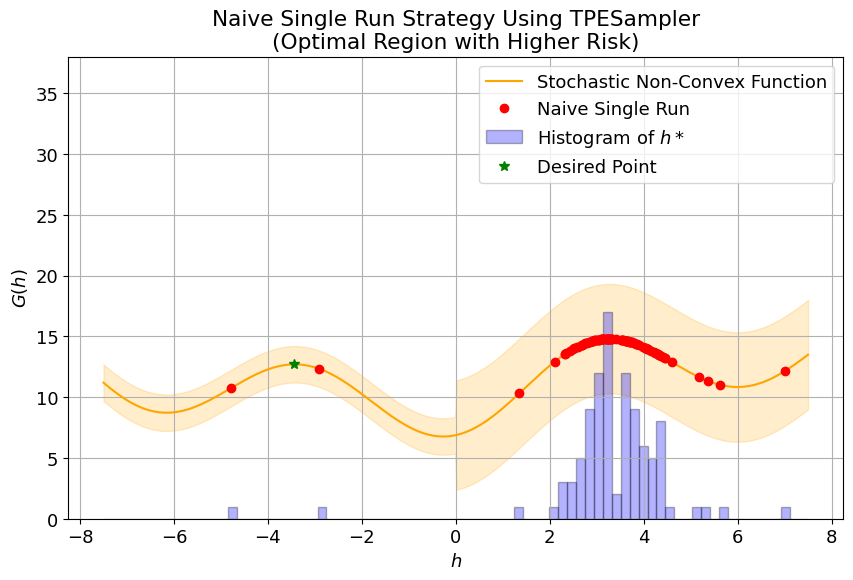

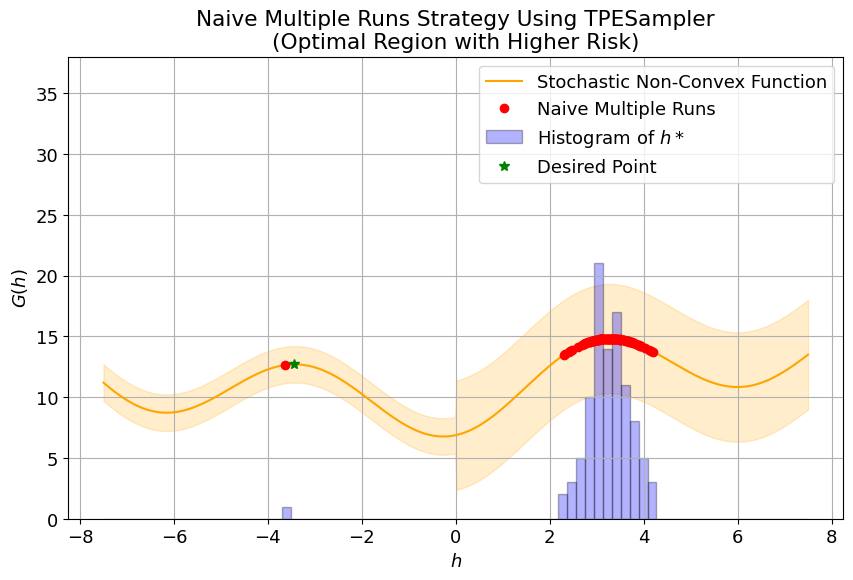

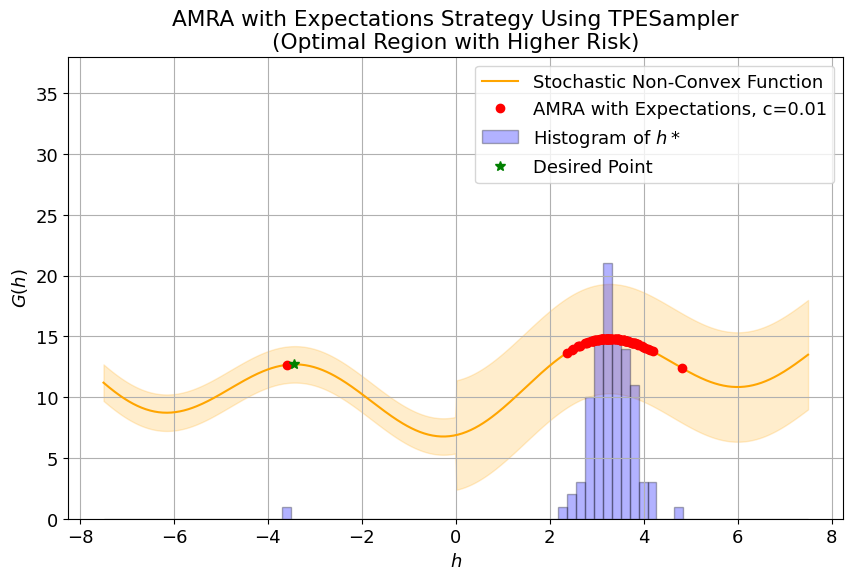

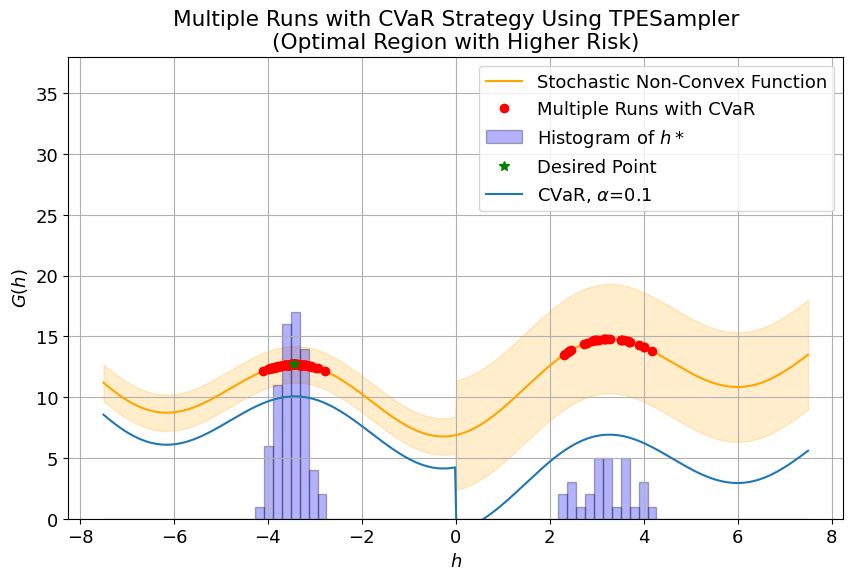

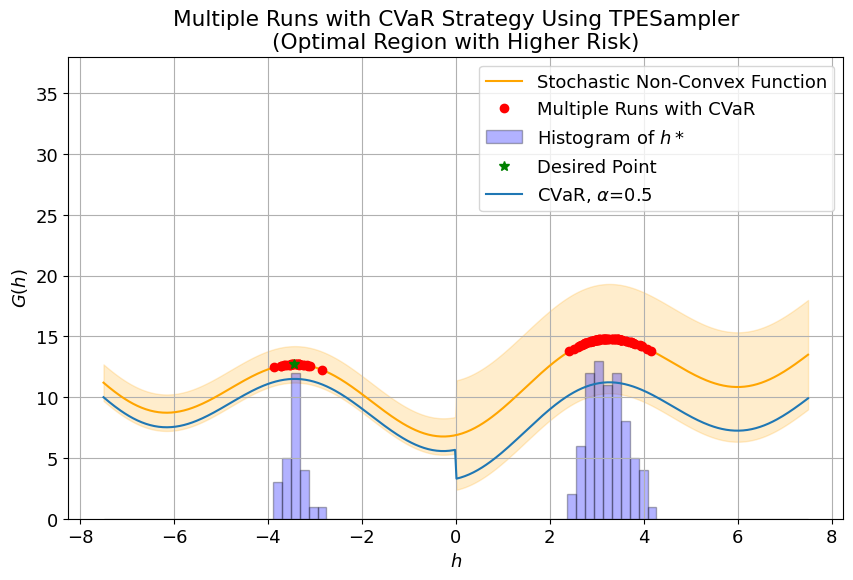

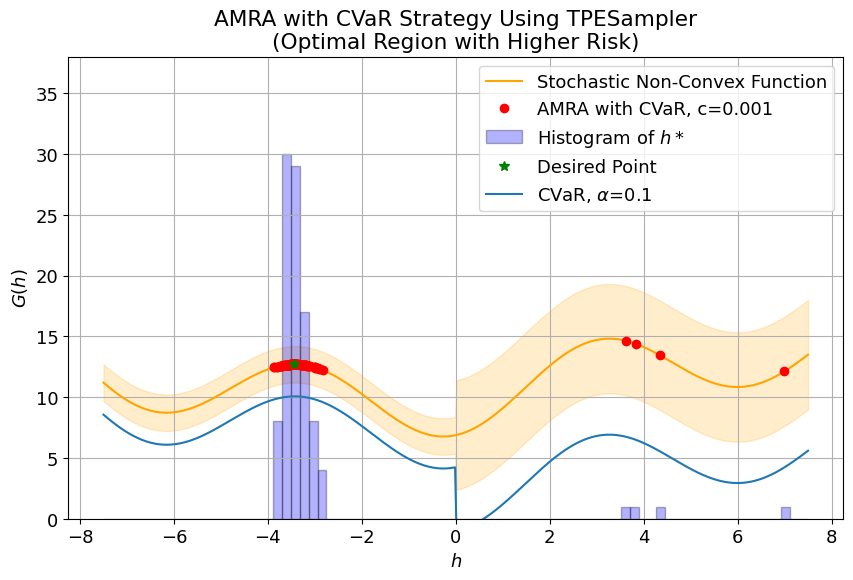

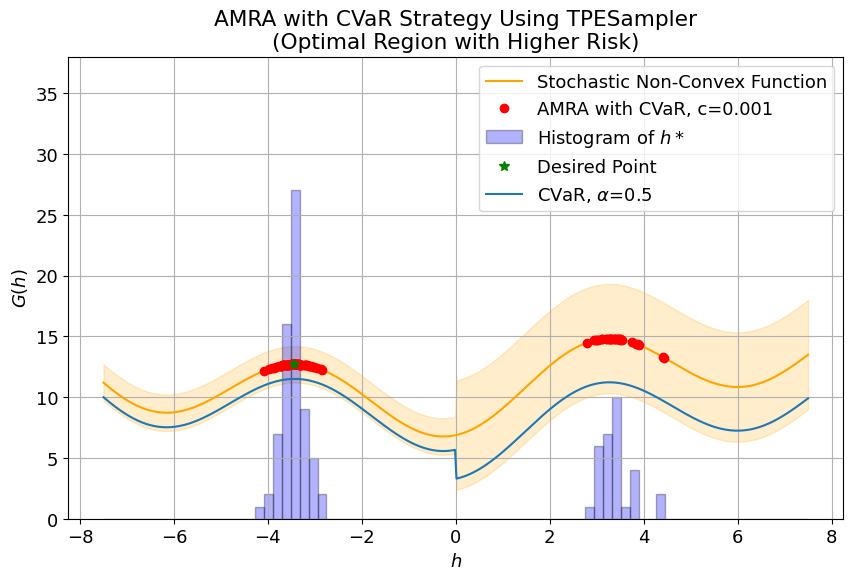

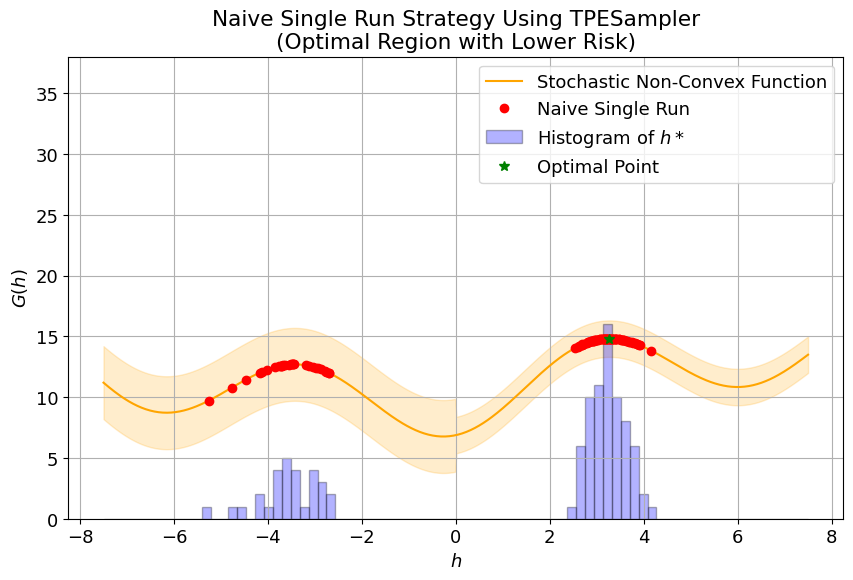

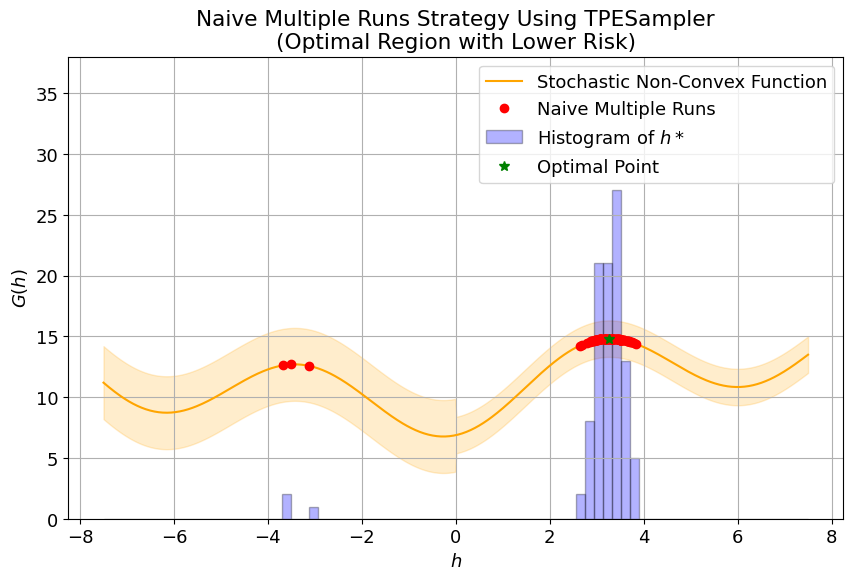

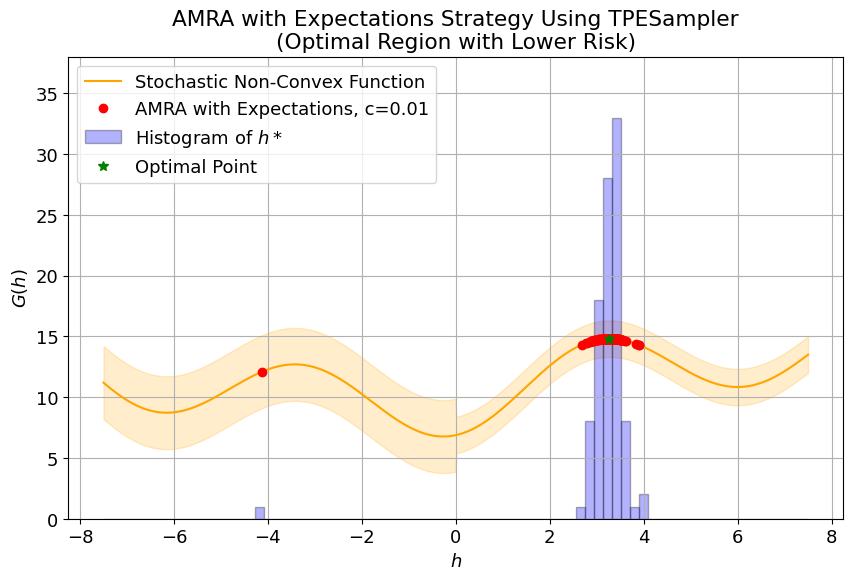

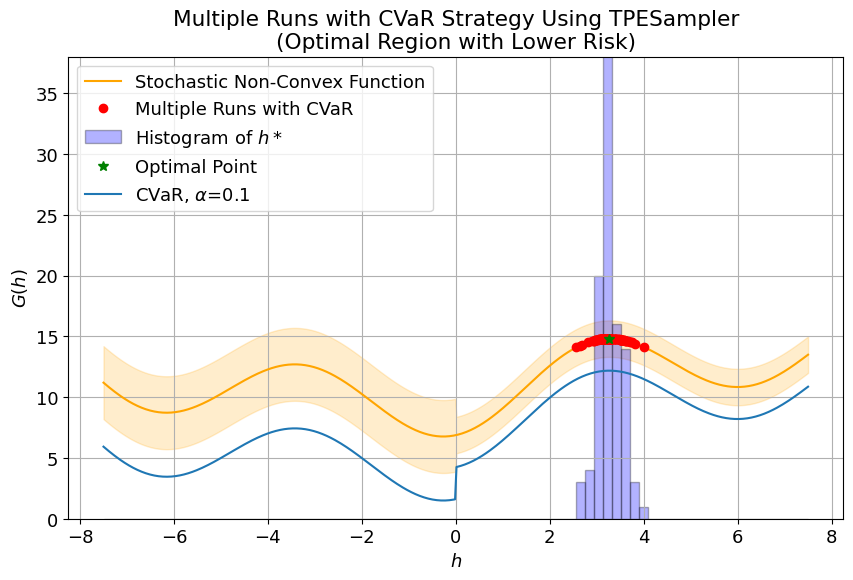

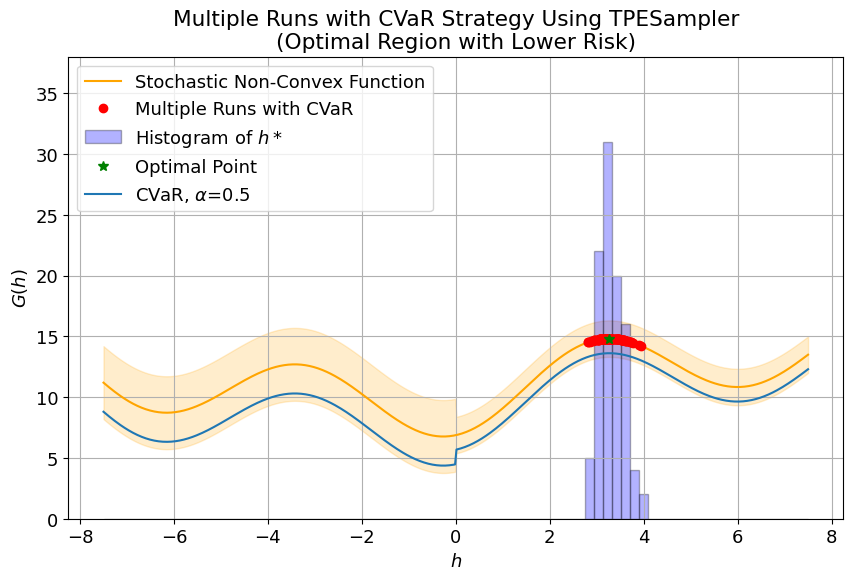

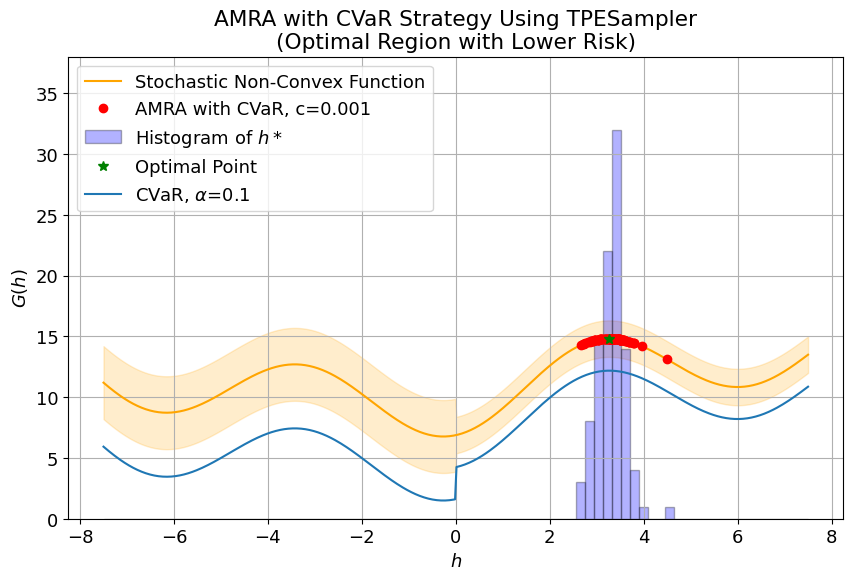

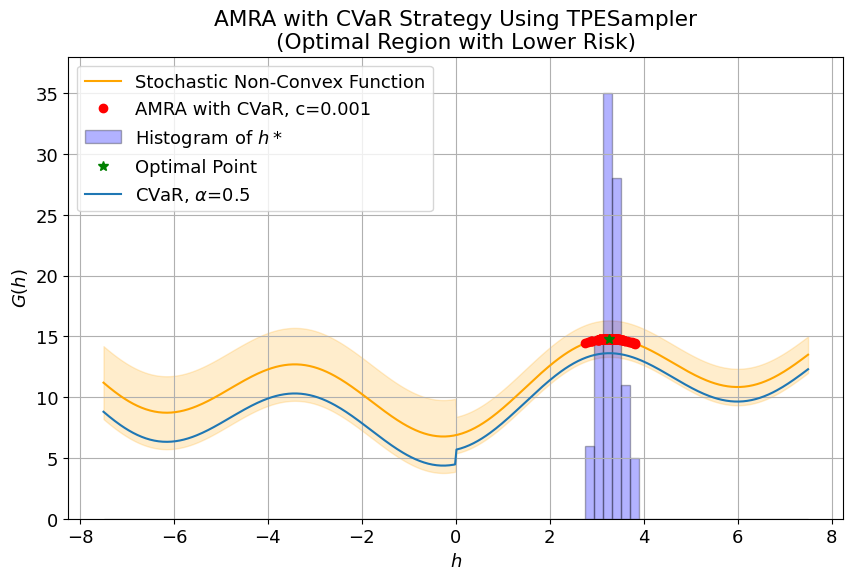

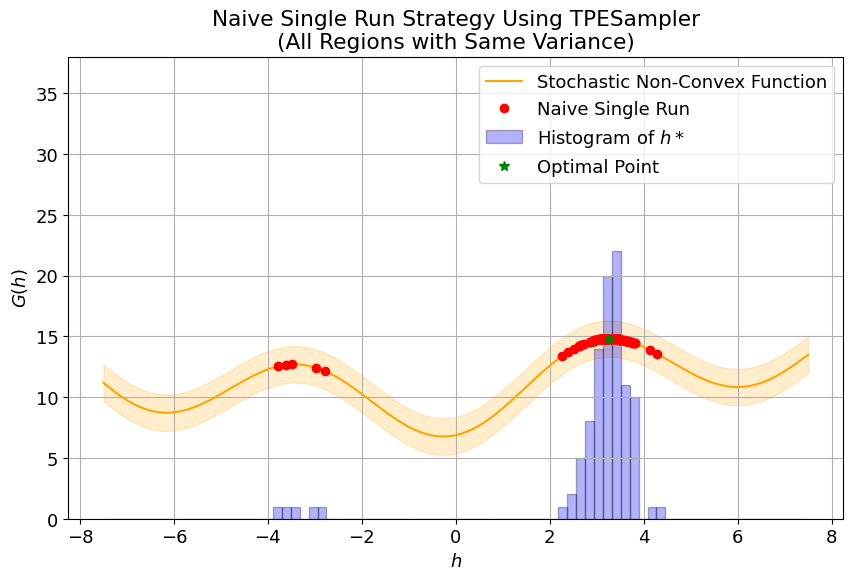

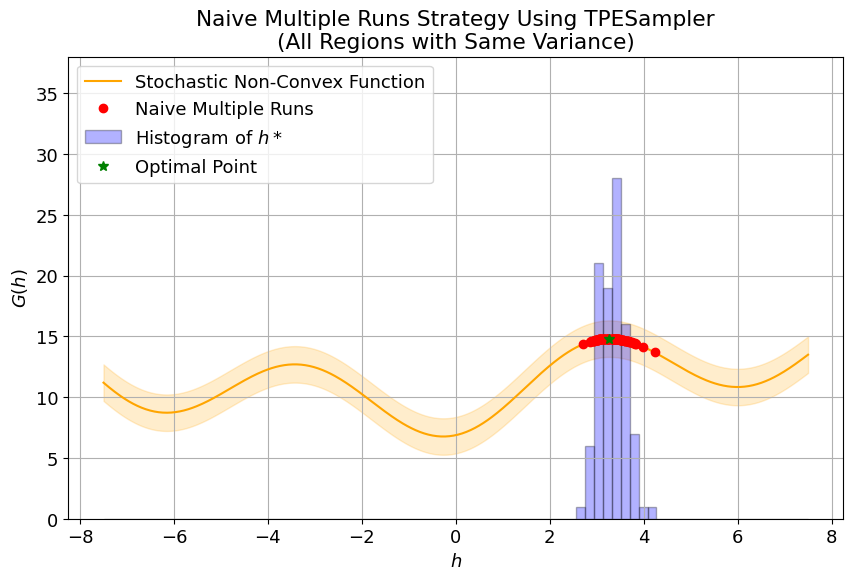

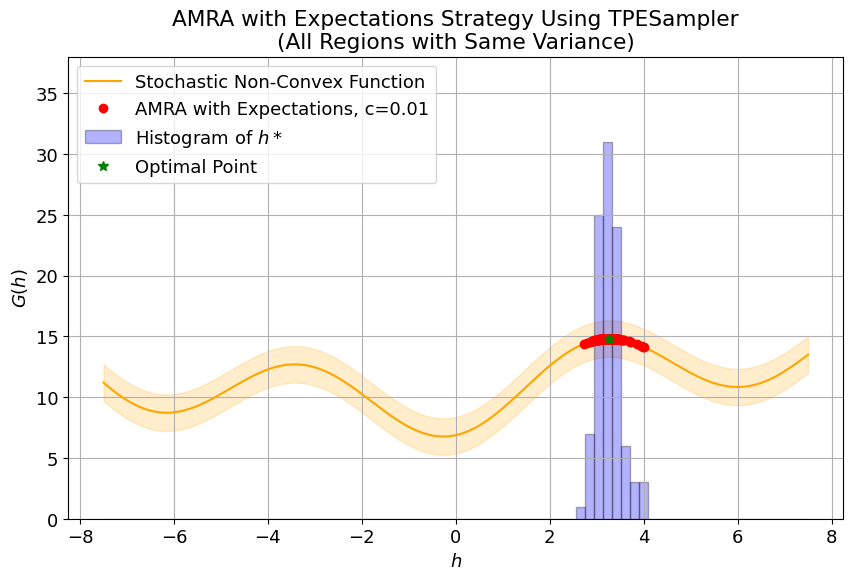

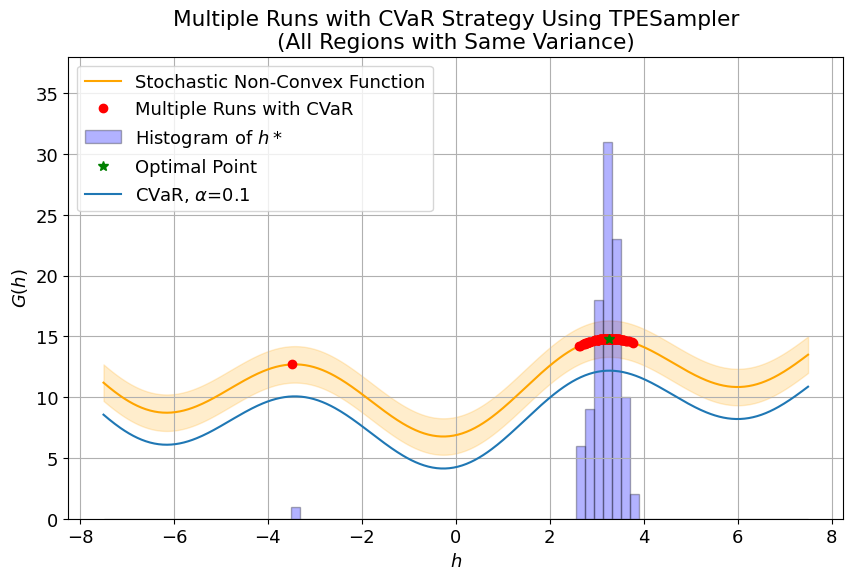

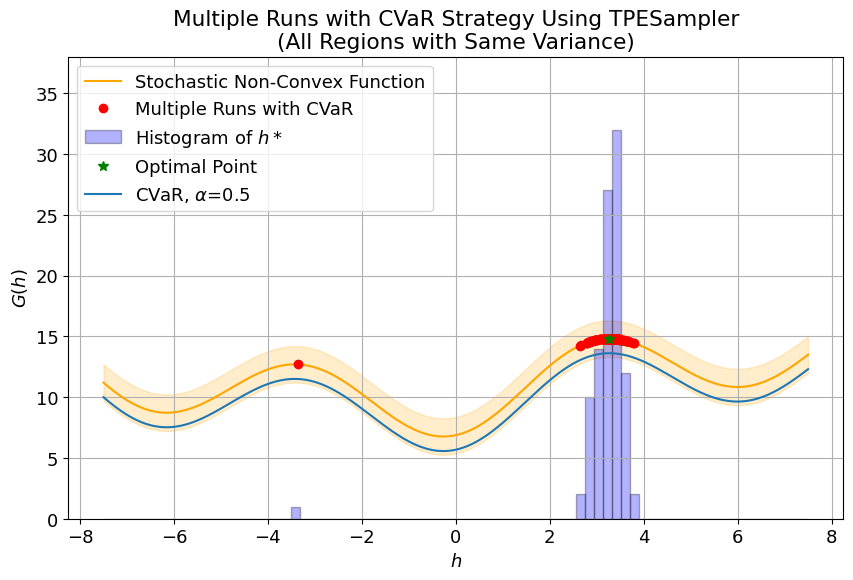

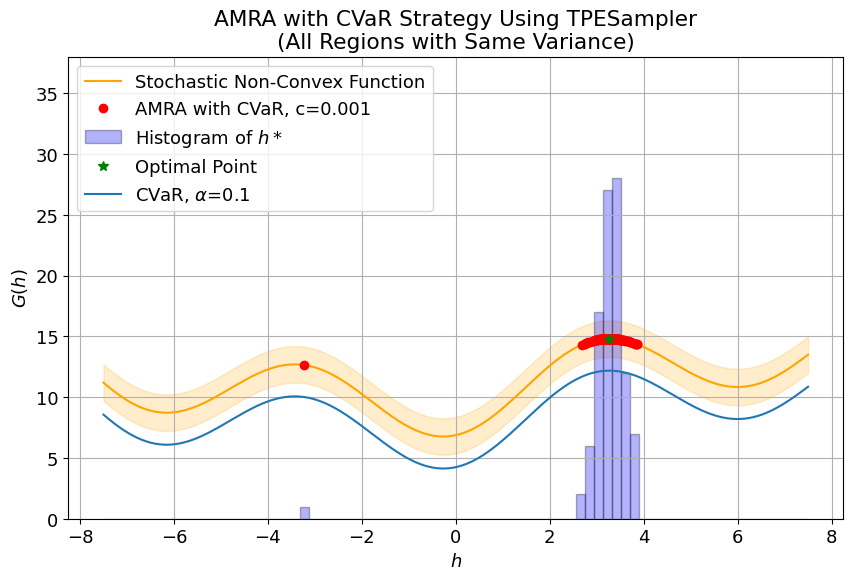

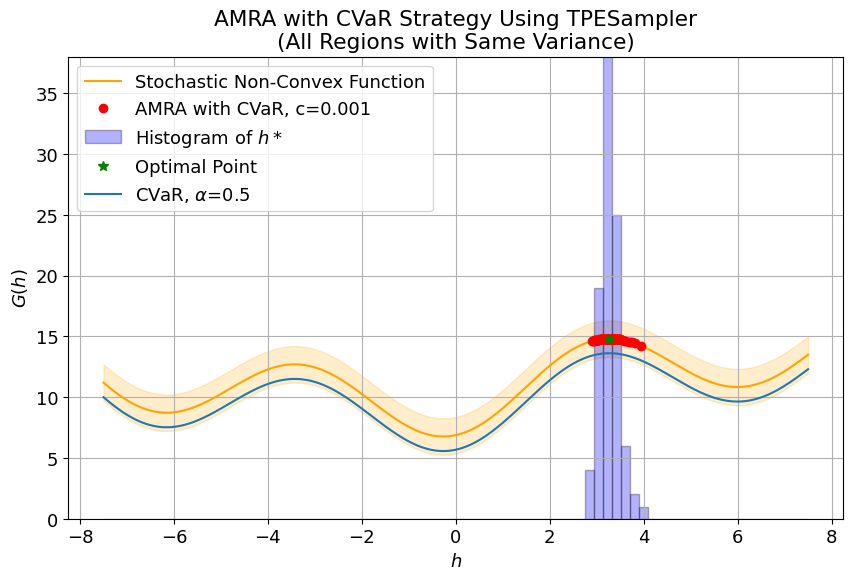

In [31]:
# load the dataframe
with open('toy_examples_df.pickle', 'rb') as fin:
    df = pickle.load(fin)
alphas = [0.1, 0.5]
samplers = ["TPESampler"]
strategies = ["naive_single_run",
              "naive_multiple_runs",
              "dynamics_runs_w/o_CVaR",
              "multiple_runs_w/_CVaR",
              "dynamics_runs_w/_CVaR"
              ]
strategy_names = {"naive_single_run": "Naive Single Run",
                  "naive_multiple_runs": "Naive Multiple Runs",
                  "multiple_runs_w/_CVaR": "Multiple Runs with CVaR",
                  "dynamics_runs_w/_CVaR": "AMRA with CVaR",
                  "dynamics_runs_w/o_CVaR": "AMRA with Expectations"}
budgets = ['num_of_trials', 'num_of_eval']
percentage_cvar = 0.001
percentage_mean = 0.01
thresholds_cvar = 15 * percentage_cvar
thresholds_mean = 15 * percentage_mean
bins = np.linspace(-7.5, 7.5, 80)
trial_to_describe = 350
# visualize the results
for noise_level in noise_levels:
    for noise_function_mode in noise_function_modes:
        for sampler in samplers:
            idx = 0
            for strategy in strategies:
                if strategy != "multiple_runs_w/_CVaR" and strategy != "dynamics_runs_w/_CVaR":
                    pass
                #     if idx == 0:
                #         fig, axs = plt.subplots(1, 3, figsize=(10 * 3, 6))
                #     if idx == 3:
                #         plt.show()
                #         plt.close()              
                if strategy == "multiple_runs_w/_CVaR":
                        
                    # plt.scatter(x, noisy_function_values, alpha=0.5, color='orange')
                    # plot data points for each strategy
                    num_cols = len(alphas)  # Number of columns for subplots
                    # fig, axs = plt.subplots(1, num_cols, figsize=(10 * num_cols, 6))
                    for idx, alpha in enumerate(alphas):
                        # ax = axs[idx]
                        plt.figure(figsize=(10, 6))
                        plt.rcParams.update({'font.size': 13})
                        # Calculate the noisy function values
                        noisy_function_values = np.array([])
                        stds = np.array([]) 
                        for xi in x:
                                # append the noisy function values to the array
                                v, std = non_convex_noisy_function(xi, noise_function_mode, noise_level)
                                noisy_function_values = np.append(noisy_function_values, v)
                                stds = np.append(stds, std) 
                                
                        plt.plot(x, original_function_values, label='Stochastic Non-Convex Function', color='orange')
                        # plot std
                        plt.fill_between(x, original_function_values - stds, original_function_values + stds, alpha=0.2, color='orange')
                        plt.plot(df.loc[df['noise_function_mode'] == noise_function_mode].loc[df['num_of_trials'] == trial_to_describe].loc[df['Sampler'] == sampler].loc[df['Strategy'] == strategy].loc[df['alpha'] == alpha]['h'], 
                                df.loc[df['noise_function_mode'] == noise_function_mode].loc[df['num_of_trials'] == trial_to_describe].loc[df['Sampler'] == sampler].loc[df['Strategy'] == strategy].loc[df['alpha'] == alpha]['G'],
                                'o', label=strategy_names[strategy], color='red')
                        plt.hist(df.loc[df['noise_function_mode'] == noise_function_mode].loc[df['num_of_trials'] == trial_to_describe].loc[df['Sampler'] == sampler].loc[df['Strategy'] == strategy].loc[df['alpha'] == alpha]['h'],
                                bins=bins, edgecolor='black', color='blue', alpha=0.3, label=r'Histogram of $h*$')
                        if noise_function_mode == 'h_e_h_v_l_e_h_v':
                                # plot the optimal point for x < 0 
                                plt.plot(x[np.argmax(original_function_values[:int(len(original_function_values)/2)])], 
                                        np.max(original_function_values[:int(len(original_function_values)/2)]), 
                                        '*', markersize=7, label="Desired Point", color='green')
                        else:
                                # plot the optimal point from original_function_values in green
                                plt.plot(x[np.argmax(original_function_values)], np.max(original_function_values), 
                                        '*', markersize=7, label="Optimal Point", color='green')
                        cvar = calculate_cvar(original_function_values, stds, alpha)
                        plt.plot(x, cvar, label=f'CVaR, ' + r'${\alpha} $' + f'={alpha}')
                        plt.xlabel(r'$h$')
                        plt.ylabel(r'$G(h)$')
                        plt.ylim(0, 38)
                        plt.title(f'{strategy_names[strategy]} Strategy Using ' + sampler + f'\n({function_modes[noise_function_mode]})')
                        plt.legend()
                        plt.grid(True)
                        plt.savefig(f'fig/experiments/{strategy_names[strategy]} ({function_modes[noise_function_mode]}, Alpha={alpha}).pdf', format="pdf")
                        plt.show()
                        plt.close()
                    # plt.show()
                    # plt.close()
                elif strategy == "dynamics_runs_w/_CVaR":
                    num_cols = len(alphas)  # Number of columns for subplots
                    # fig, axs = plt.subplots(1, num_cols, figsize=(10 * num_cols, 6))
                    for idx, alpha in enumerate(alphas):
                        # ax = axs[idx] 
                        plt.figure(figsize=(10, 6))
                        plt.rcParams.update({'font.size': 13})
                        # Calculate the noisy function values
                        noisy_function_values = np.array([])
                        stds = np.array([]) 
                        for xi in x:
                                # append the noisy function values to the array
                                v, std = non_convex_noisy_function(xi, noise_function_mode, noise_level)
                                noisy_function_values = np.append(noisy_function_values, v)
                                stds = np.append(stds, std) 
                                
                        plt.plot(x, original_function_values, label='Stochastic Non-Convex Function', color='orange')
                        # plot std
                        plt.fill_between(x, original_function_values - stds, original_function_values + stds, alpha=0.2, color='orange')
                        plt.plot(df.loc[df['noise_function_mode'] == noise_function_mode].loc[df['num_of_trials'] == trial_to_describe].loc[df['Sampler'] == sampler].loc[df['Strategy'] == strategy].loc[df['alpha'] == alpha]['h'], 
                                df.loc[df['noise_function_mode'] == noise_function_mode].loc[df['num_of_trials'] == trial_to_describe].loc[df['Sampler'] == sampler].loc[df['Strategy'] == strategy].loc[df['alpha'] == alpha]['G'],
                                'o', label=strategy_names[strategy]+ f', c={percentage_cvar}', color='red')
                        plt.hist(df.loc[df['noise_function_mode'] == noise_function_mode].loc[df['num_of_trials'] == trial_to_describe].loc[df['Sampler'] == sampler].loc[df['Strategy'] == strategy].loc[df['alpha'] == alpha]['h'],
                                bins=bins, edgecolor='black', color='blue', alpha=0.3, label=r'Histogram of $h*$')
                        if noise_function_mode == 'h_e_h_v_l_e_h_v':
                                # plot the optimal point for x < 0 
                                plt.plot(x[np.argmax(original_function_values[:int(len(original_function_values)/2)])], 
                                        np.max(original_function_values[:int(len(original_function_values)/2)]), 
                                        '*', markersize=7, label="Desired Point", color='green')
                        else:
                                # plot the optimal point from original_function_values in green
                                plt.plot(x[np.argmax(original_function_values)], np.max(original_function_values), 
                                        '*', markersize=7, label="Optimal Point", color='green')
                        cvar = calculate_cvar(original_function_values, stds, alpha)
                        plt.plot(x, cvar, label=f'CVaR, ' + r'${\alpha} $' + f'={alpha}')
                        plt.xlabel(r'$h$')
                        plt.ylabel(r'$G(h)$')
                        plt.ylim(0, 38)
                        plt.title(f'{strategy_names[strategy]} Strategy Using ' + sampler + f'\n({function_modes[noise_function_mode]})')
                        plt.legend()
                        plt.grid(True)
                        plt.savefig(f'fig/experiments/{strategy_names[strategy]} ({function_modes[noise_function_mode]}, Alpha={alpha}, c={percentage_cvar}).pdf', format="pdf")
                        plt.show()
                        plt.close()
                    # plt.show()
                    # plt.close()
                else:
                    # ax = axs[idx]
                    # idx += 1
                    plt.figure(figsize=(10, 6))
                    plt.rcParams.update({'font.size': 13})
                    # Calculate the noisy function values
                    noisy_function_values = np.array([])
                    stds = np.array([]) 
                    for xi in x:
                        # append the noisy function values to the array
                        v, std = non_convex_noisy_function(xi, noise_function_mode, noise_level)
                        noisy_function_values = np.append(noisy_function_values, v)
                        stds = np.append(stds, std) 
                                
                    plt.plot(x, original_function_values, label='Stochastic Non-Convex Function', color='orange')
                    # plot std
                    plt.fill_between(x, original_function_values - stds, original_function_values + stds, alpha=0.2, color='orange')
                    if strategy == "dynamics_runs_w/o_CVaR":
                        plt.plot(df.loc[df['noise_function_mode'] == noise_function_mode].loc[df['num_of_trials'] == trial_to_describe].loc[df['Sampler'] == sampler].loc[df['Strategy'] == strategy]['h'], 
                                df.loc[df['noise_function_mode'] == noise_function_mode].loc[df['num_of_trials'] == trial_to_describe].loc[df['Sampler'] == sampler].loc[df['Strategy'] == strategy]['G'],
                                'o', label=strategy_names[strategy]+ f', c={percentage_mean}', color='red')
                    else:
                        plt.plot(df.loc[df['noise_function_mode'] == noise_function_mode].loc[df['num_of_trials'] == trial_to_describe].loc[df['Sampler'] == sampler].loc[df['Strategy'] == strategy]['h'], 
                            df.loc[df['noise_function_mode'] == noise_function_mode].loc[df['num_of_trials'] == trial_to_describe].loc[df['Sampler'] == sampler].loc[df['Strategy'] == strategy]['G'],
                            'o', label=strategy_names[strategy], color='red')
                    plt.hist(df.loc[df['noise_function_mode'] == noise_function_mode].loc[df['num_of_trials'] == trial_to_describe].loc[df['Sampler'] == sampler].loc[df['Strategy'] == strategy]['h'],
                            bins=bins, edgecolor='black', color='blue', alpha=0.3, label=r'Histogram of $h*$')
                    
                    if noise_function_mode == 'h_e_h_v_l_e_h_v':
                        # plot the optimal point for x < 0 
                        plt.plot(x[np.argmax(original_function_values[:int(len(original_function_values)/2)])], 
                                np.max(original_function_values[:int(len(original_function_values)/2)]), 
                                '*', markersize=7, label="Desired Point", color='green')
                    else:
                        # plot the optimal point from original_function_values in green
                        plt.plot(x[np.argmax(original_function_values)], np.max(original_function_values), 
                                '*', markersize=7, label="Optimal Point", color='green')

                    plt.xlabel(r'$h$')
                    plt.ylabel(r'$G(h)$')
                    plt.ylim(0, 38)
                    plt.title(f'{strategy_names[strategy]} Strategy Using ' + sampler + f'\n({function_modes[noise_function_mode]})')
                    plt.legend()
                    plt.grid(True)
                    plt.savefig(f'fig/experiments/{strategy_names[strategy]} ({function_modes[noise_function_mode]}).pdf', format="pdf")
                    plt.show()
                    plt.close()

In [15]:
# only describe certain num_of_trials and G
df[df['num_of_trials'] == trial_to_describe].groupby(['Sampler', 'noise_function_modes', 'Strategy', 'num_of_trials']).describe()['G']

count  \
Sampler       noise_function_modes Strategy               num_of_trials          
RandomSampler h_e_h_v_l_e_h_v      dynamics_runs_w/_CVaR  30             200.0   
                                   dynamics_runs_w/o_CVaR 30             200.0   
                                   multiple_runs_w/_CVaR  30             200.0   
                                   naive_multiple_runs    30             200.0   
                                   naive_single_run       30             200.0   
              h_e_l_v_l_e_h_v      dynamics_runs_w/_CVaR  30             200.0   
                                   dynamics_runs_w/o_CVaR 30             200.0   
                                   multiple_runs_w/_CVaR  30             200.0   
                                   naive_multiple_runs    30             200.0   
                                   naive_single_run       30             200.0   
              h_e_l_v_l_e_l_v      dynamics_runs_w/_CVaR  30             200.0   
                                   dynamics_runs_w/o_CVaR 30             200.0   
                                   multiple_runs_w/_CVaR  30             200.0   
                                   naive_multiple_runs    30             200.0   
                                   naive_single_run       30             200.0   
TPESampler    h_e_h_v_l_e_h_v      dynamics_runs_w/_CVaR  30             200.0   
                                   dynamics_runs_w/o_CVaR 30             200.0   
                                   multiple_runs_w/_CVaR  30             200.0   
                                   naive_multiple_runs    30             200.0   
                                   naive_single_run       30             200.0   
              h_e_l_v_l_e_h_v      dynamics_runs_w/_CVaR  30             200.0   
                                   dynamics_runs_w/o_CVaR 30             200.0   
                                   multiple_runs_w/_CVaR  30             200.0   
                                   naive_multiple_runs    30             200.0   
                                   naive_single_run       30             200.0   
              h_e_l_v_l_e_l_v      dynamics_runs_w/_CVaR  30             200.0   
                                   dynamics_runs_w/o_CVaR 30             200.0   
                                   multiple_runs_w/_CVaR  30             200.0   
                                   naive_multiple_runs    30             200.0   
                                   naive_single_run       30             200.0   

                                                                              mean  \
Sampler       noise_function_modes Strategy               num_of_trials              
RandomSampler h_e_h_v_l_e_h_v      dynamics_runs_w/_CVaR  30             13.129223   
                                   dynamics_runs_w/o_CVaR 30             13.507545   
                                   multiple_runs_w/_CVaR  30             13.003449   
                                   naive_multiple_runs    30             13.167332   
                                   naive_single_run       30             12.867053   
              h_e_l_v_l_e_h_v      dynamics_runs_w/_CVaR  30             13.945383   
                                   dynamics_runs_w/o_CVaR 30             13.658685   
                                   multiple_runs_w/_CVaR  30             13.324585   
                                   naive_multiple_runs    30             13.128440   
                                   naive_single_run       30             12.505191   
              h_e_l_v_l_e_l_v      dynamics_runs_w/_CVaR  30             14.191124   
                                   dynamics_runs_w/o_CVaR 30             14.245390   
                                   multiple_runs_w/_CVaR  30             13.854366   
                                   naive_multiple_runs    30             13.957429   
                                   naive_single_run       30            

In [16]:
# only describe certain num_of_trials and std
df[df['num_of_trials'] == trial_to_describe].groupby(['Sampler', 'noise_function_modes', 'Strategy', 'num_of_trials']).describe()['std']

count  \
Sampler       noise_function_modes Strategy               num_of_trials          
RandomSampler h_e_h_v_l_e_h_v      dynamics_runs_w/_CVaR  30             200.0   
                                   dynamics_runs_w/o_CVaR 30             200.0   
                                   multiple_runs_w/_CVaR  30             200.0   
                                   naive_multiple_runs    30             200.0   
                                   naive_single_run       30             200.0   
              h_e_l_v_l_e_h_v      dynamics_runs_w/_CVaR  30             200.0   
                                   dynamics_runs_w/o_CVaR 30             200.0   
                                   multiple_runs_w/_CVaR  30             200.0   
                                   naive_multiple_runs    30             200.0   
                                   naive_single_run       30             200.0   
              h_e_l_v_l_e_l_v      dynamics_runs_w/_CVaR  30             200.0   
                                   dynamics_runs_w/o_CVaR 30             200.0   
                                   multiple_runs_w/_CVaR  30             200.0   
                                   naive_multiple_runs    30             200.0   
                                   naive_single_run       30             200.0   
TPESampler    h_e_h_v_l_e_h_v      dynamics_runs_w/_CVaR  30             200.0   
                                   dynamics_runs_w/o_CVaR 30             200.0   
                                   multiple_runs_w/_CVaR  30             200.0   
                                   naive_multiple_runs    30             200.0   
                                   naive_single_run       30             200.0   
              h_e_l_v_l_e_h_v      dynamics_runs_w/_CVaR  30             200.0   
                                   dynamics_runs_w/o_CVaR 30             200.0   
                                   multiple_runs_w/_CVaR  30             200.0   
                                   naive_multiple_runs    30             200.0   
                                   naive_single_run       30             200.0   
              h_e_l_v_l_e_l_v      dynamics_runs_w/_CVaR  30             200.0   
                                   dynamics_runs_w/o_CVaR 30             200.0   
                                   multiple_runs_w/_CVaR  30             200.0   
                                   naive_multiple_runs    30             200.0   
                                   naive_single_run       30             200.0   

                                                                           mean  \
Sampler       noise_function_modes Strategy               num_of_trials           
RandomSampler h_e_h_v_l_e_h_v      dynamics_runs_w/_CVaR  30             5.7300   
                                   dynamics_runs_w/o_CVaR 30             6.5550   
                                   multiple_runs_w/_CVaR  30             6.3300   
                                   naive_multiple_runs    30             6.7050   
                                   naive_single_run       30             6.7500   
              h_e_l_v_l_e_h_v      dynamics_runs_w/_CVaR  30             2.5575   
                                   dynamics_runs_w/o_CVaR 30             2.9850   
                                   multiple_runs_w/_CVaR  30             3.0525   
                                   naive_multiple_runs    30             3.3750   
                                   naive_single_run       30             3.7200   
              h_e_l_v_l_e_l_v      dynamics_runs_w/_CVaR  30             2.2500   
                                   dynamics_runs_w/o_CVaR 30             2.2500   
                                   multiple_runs_w/_CVaR  30             2.2500   
                                   naive_multiple_runs    30             2.2500   
                                   naive_single_run       30             2.2500   
TPESampler    h_e_h_v_l_e_h_v      dy

In [35]:
# only describe certain num_of_trials and h
df[df['num_of_trials'] == trial_to_describe].groupby(['Sampler', 'noise_function_modes', 'Strategy', 'num_of_trials']).describe()['h']

count  \
Sampler       noise_function_modes Strategy               num_of_trials          
RandomSampler h_e_h_v_l_e_h_v      dynamics_runs_w/_CVaR  10             120.0   
                                   dynamics_runs_w/o_CVaR 10             120.0   
                                   multiple_runs_w/_CVaR  10             120.0   
                                   naive_multiple_runs    10             120.0   
                                   naive_single_run       10             120.0   
              h_e_h_v_l_e_l_v      dynamics_runs_w/_CVaR  10             120.0   
                                   dynamics_runs_w/o_CVaR 10             120.0   
                                   multiple_runs_w/_CVaR  10             120.0   
                                   naive_multiple_runs    10             120.0   
                                   naive_single_run       10             120.0   
              h_e_l_v_l_e_h_v      dynamics_runs_w/_CVaR  10             120.0   
                                   dynamics_runs_w/o_CVaR 10             120.0   
                                   multiple_runs_w/_CVaR  10             120.0   
                                   naive_multiple_runs    10             120.0   
                                   naive_single_run       10             120.0   
              h_e_l_v_l_e_l_v      dynamics_runs_w/_CVaR  10             120.0   
                                   dynamics_runs_w/o_CVaR 10             120.0   
                                   multiple_runs_w/_CVaR  10             120.0   
                                   naive_multiple_runs    10             120.0   
                                   naive_single_run       10             120.0   
TPESampler    h_e_h_v_l_e_h_v      dynamics_runs_w/_CVaR  10             120.0   
                                   dynamics_runs_w/o_CVaR 10             120.0   
                                   multiple_runs_w/_CVaR  10             120.0   
                                   naive_multiple_runs    10             120.0   
                                   naive_single_run       10             120.0   
              h_e_h_v_l_e_l_v      dynamics_runs_w/_CVaR  10             120.0   
                                   dynamics_runs_w/o_CVaR 10             120.0   
                                   multiple_runs_w/_CVaR  10             120.0   
                                   naive_multiple_runs    10             120.0   
                                   naive_single_run       10             120.0   
              h_e_l_v_l_e_h_v      dynamics_runs_w/_CVaR  10             120.0   
                                   dynamics_runs_w/o_CVaR 10             120.0   
                                   multiple_runs_w/_CVaR  10             120.0   
                                   naive_multiple_runs    10             120.0   
                                   naive_single_run       10             120.0   
              h_e_l_v_l_e_l_v      dynamics_runs_w/_CVaR  10             120.0   
                                   dynamics_runs_w/o_CVaR 10             120.0   
                                   multiple_runs_w/_CVaR  10             120.0   
                                   naive_multiple_runs    10             120.0   
                                   naive_single_run       10             120.0   

                                                                             mean  \
Sampler       noise_function_modes Strategy               num_of_trials             
RandomSampler h_e_h_v_l_e_h_v      dynamics_runs_w/_CVaR  10             0.990741   
                                   dynamics_runs_w/o_CVaR 10             1.396563   
                                   multiple_runs_w/_CVaR  10             1.720581   
                                   naive_multiple_runs    10             1.804070   
                                   naive_single_run       10             1.160921   
              h_e_h_v_l_e_l_v    

Hoeffding

In [49]:
def hoeffding_bound(n, range_a, range_b, t):
    return 2 * np.exp(-2 * n * t**2 / ((range_b - range_a)**2))

hoeffding_bound(40, 10, 20, 3.5)

0.00011090319886435389

In [63]:

# spec
noise_function_modes = ["h_e_h_v_l_e_h_v", 
                        # "h_e_h_v_l_e_l_v", 
                        "h_e_l_v_l_e_h_v", 
                        "h_e_l_v_l_e_l_v"]
samplers = ["TPESampler"] # ["TPESampler", "RandomSampler"]
strategies = ["Hoeffding_w/_CVaR",
              "Hoeffding_w/o_CVaR"]
budgets = ['num_of_trials', 'num_of_eval']
noise_levels = [
                "Low",
                # "High"
                ]
times = 100
trials = [350]
# trials = [200, 350]
alphas = [0.1, 0.5] # [0.1, 0.5]
warm_trials = 1
percentage_cvar = 0.001
percentage_mean = 0.01
thresholds_cvar = 15 * percentage_cvar
thresholds_mean = 15 * percentage_mean
range_ab = [10, 20]


# number of samples in each partition
num_samples_in_partition_mean = 4
num_samples_in_partition_cvars = 8

def hoeffding_bound(n, range_a, range_b, t):
    return 2 * np.exp(-2 * n * t**2 / ((range_b - range_a)**2))

def hoeffding_objective(trial, s, noise_function_mode, noise_level, threshold, repitition, alpha):
    G = 0
    if s == "Hoeffding_w/_CVaR":
        increase_runs = True
        f = []
        h = trial.suggest_float("h", -7.5, 7.5)
        while increase_runs:
            increase_runs = False
            for _ in range(repitition):
                v, _ = non_convex_noisy_function(h, noise_function_mode, noise_level)
                f.append(v[0])
                with open("num_of_eval.pickle", "rb") as fin:
                    num_of_eval = pickle.load(fin)
                num_of_eval += 1
                with open("num_of_eval.pickle", "wb") as fout:
                    pickle.dump(num_of_eval, fout)
            Gss = _compute_cvar(np.array(f), alpha)

            # if the current objective is better than the best objective, trigger more runs to avoid maximization bias
            if warm_trials < len(study.trials):
                if Gss > study.best_value:
                    if hoeffding_bound(len(f), range_ab[0], range_ab[1], Gss - study.best_value) > threshold:
                        increase_runs = True
                    else:
                        increase_runs = False
        G = Gss
    elif s == "Hoeffding_w/o_CVaR":
        increase_runs = True
        f = []
        h = trial.suggest_float("h", -7.5, 7.5)
        while increase_runs:
            increase_runs = False
            for _ in range(repitition):
                v, _ = non_convex_noisy_function(h, noise_function_mode, noise_level)
                f.append(v[0])
                with open("num_of_eval.pickle", "rb") as fin:
                    num_of_eval = pickle.load(fin)
                num_of_eval += 1
                with open("num_of_eval.pickle", "wb") as fout:
                    pickle.dump(num_of_eval, fout)
            Gss = np.mean(f)

            # if the current objective is better than the best objective, trigger more runs to avoid maximization bias
            if warm_trials < len(study.trials):
                if Gss > study.best_value:
                    if hoeffding_bound(len(f), range_ab[0], range_ab[1], Gss - study.best_value) > threshold:
                        increase_runs = True
                    else:
                        increase_runs = False
        G = Gss
    return G
    

optuna.logging.set_verbosity(optuna.logging.WARNING)
# Create an empty DataFrame
hoeffding_df = pd.DataFrame(columns=['Sampler', 'G', 'std', 'h', 'Strategy', 'num_of_eval', 'num_of_trials', 'alpha', 'error_percentage', 'noise_function_mode'])

for noise_level in noise_levels:
    for noise_function_mode in noise_function_modes:
        for trial in trials:
            for sampler in samplers:
                for s in strategies:
                    for _ in range(times):
                        num_of_eval = 0
                        with open("num_of_eval.pickle", "wb") as fout:
                            pickle.dump(num_of_eval, fout)
                        
                        if s == "Hoeffding_w/_CVaR":
                            error_percentage = percentage_cvar
                            threshold = thresholds_cvar
                            repitition = num_samples_in_partition_cvars
                            for alpha in alphas:
                                if sampler == "TPESampler":
                                    study = optuna.create_study(sampler=TPESampler(n_startup_trials=5), direction="maximize")
                                elif sampler == "RandomSampler":
                                    study = optuna.create_study(sampler=RandomSampler(), direction="maximize")
                                study.optimize(lambda trial: hoeffding_objective(trial, s, noise_function_mode, noise_level, threshold, repitition, alpha), n_trials=trial)
                                best_params = study.best_params
                                with open("num_of_eval.pickle", "rb") as fin:
                                    num_of_eval = pickle.load(fin)
                                _, std = non_convex_noisy_function(best_params["h"], noise_function_mode, noise_level)
                                # Append data to temporary DataFrame
                                temp_df = pd.DataFrame({"Sampler": [sampler],
                                                        "G": [non_convex_function(best_params["h"])],
                                                        'std': [std],
                                                        "h": [best_params["h"]],  
                                                        "Strategy": [s],
                                                        "num_of_eval": [num_of_eval],
                                                        "num_of_trials": [len(study.trials)],
                                                        "alpha": [alpha],
                                                        "error_percentage": [error_percentage],
                                                        "noise_function_mode": [noise_function_mode]})

                                # Concatenate temporary DataFrame with main DataFrame
                                hoeffding_df = pd.concat([hoeffding_df, temp_df], ignore_index=True)
                        elif s == "Hoeffding_w/o_CVaR":
                            if sampler == "TPESampler":
                                study = optuna.create_study(sampler=TPESampler(n_startup_trials=5), direction="maximize")
                            elif sampler == "RandomSampler":
                                study = optuna.create_study(sampler=RandomSampler(), direction="maximize")
                            alpha = 1
                            error_percentage = percentage_mean
                            threshold = thresholds_mean
                            repitition = num_samples_in_partition_mean
                            study.optimize(lambda trial: hoeffding_objective(trial, s, noise_function_mode, noise_level, threshold, repitition, alpha), n_trials=trial)
                            best_params = study.best_params
                            with open("num_of_eval.pickle", "rb") as fin:
                                num_of_eval = pickle.load(fin)
                            _, std = non_convex_noisy_function(best_params["h"], noise_function_mode, noise_level)
                            # Append data to temporary DataFrame
                            temp_df = pd.DataFrame({"Sampler": [sampler],
                                                    "G": [non_convex_function(best_params["h"])],
                                                    'std': [std],
                                                    "h": [best_params["h"]],  
                                                    "Strategy": [s],
                                                    "num_of_eval": [num_of_eval],
                                                    "num_of_trials": [len(study.trials)],
                                                    "alpha": [alpha],
                                                    "error_percentage": [error_percentage],
                                                    "noise_function_mode": [noise_function_mode]})

                            # Concatenate temporary DataFrame with main DataFrame
                            hoeffding_df = pd.concat([hoeffding_df, temp_df], ignore_index=True)
                        

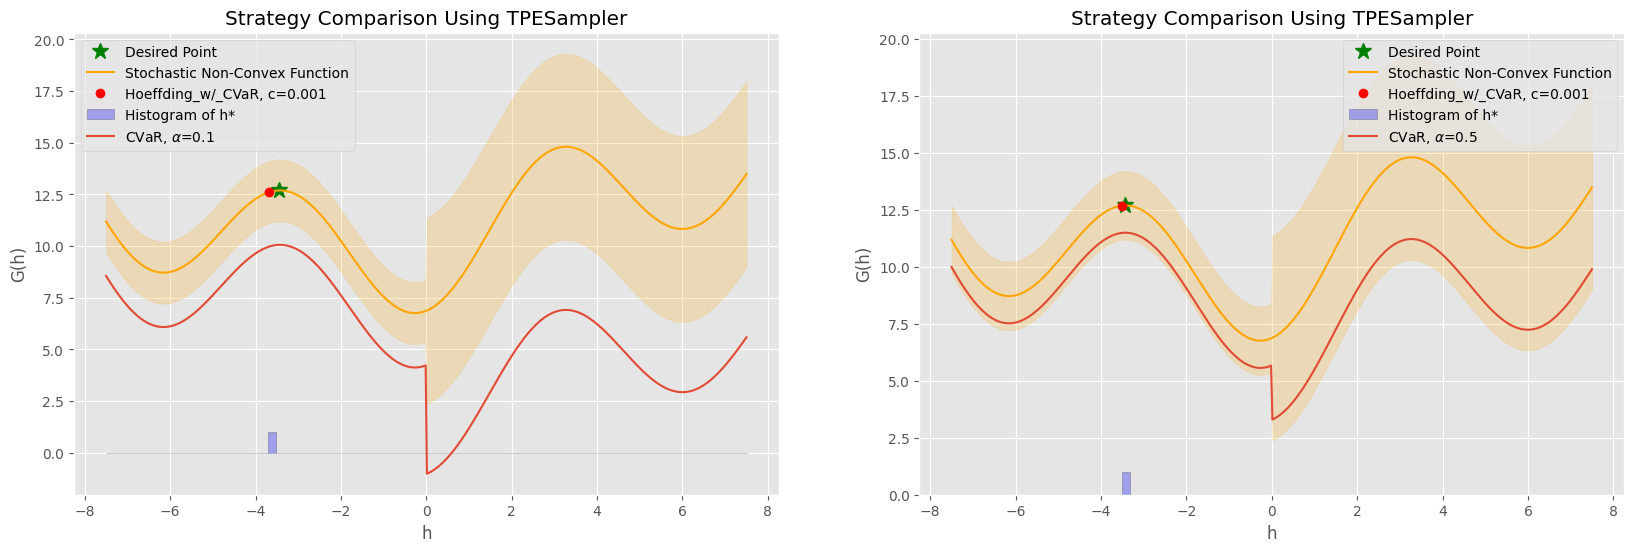

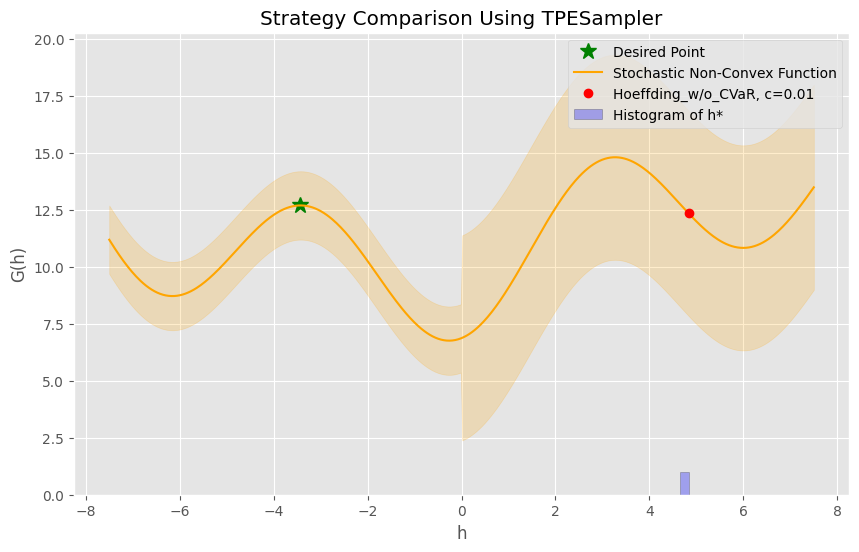

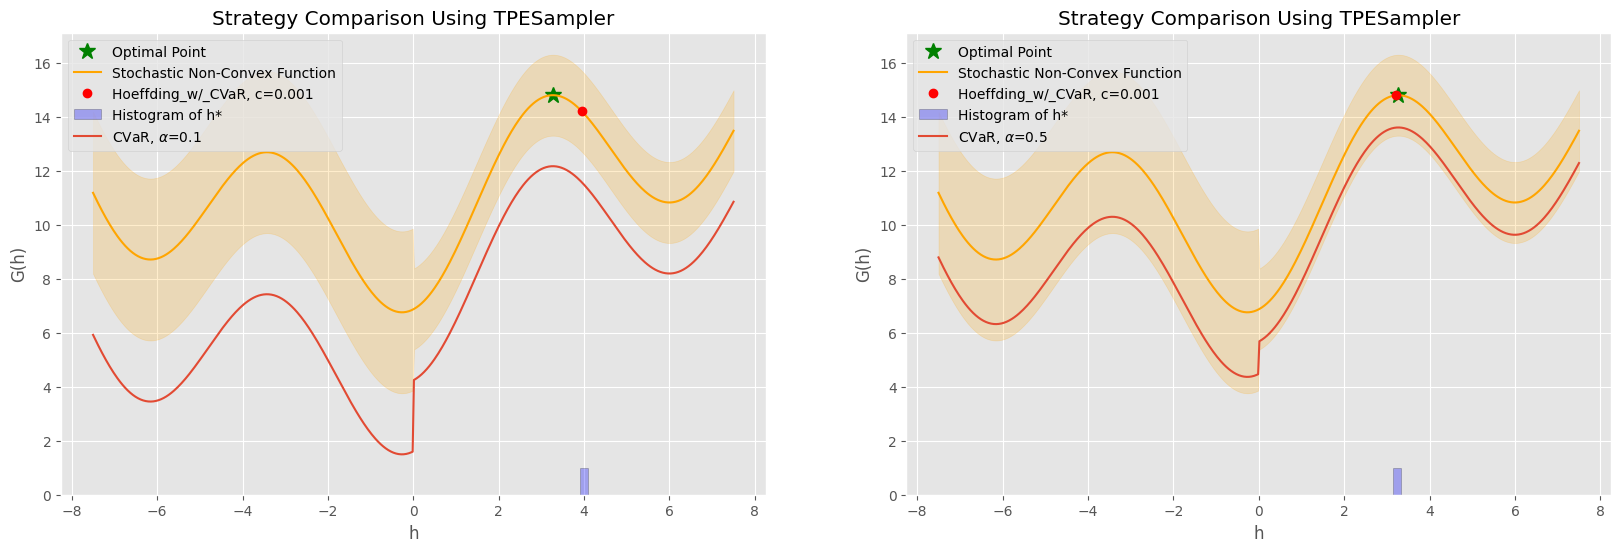

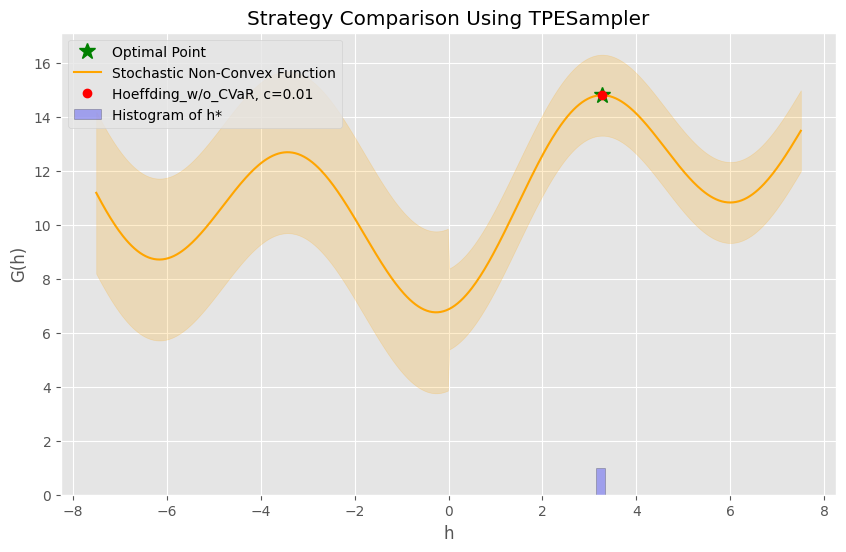

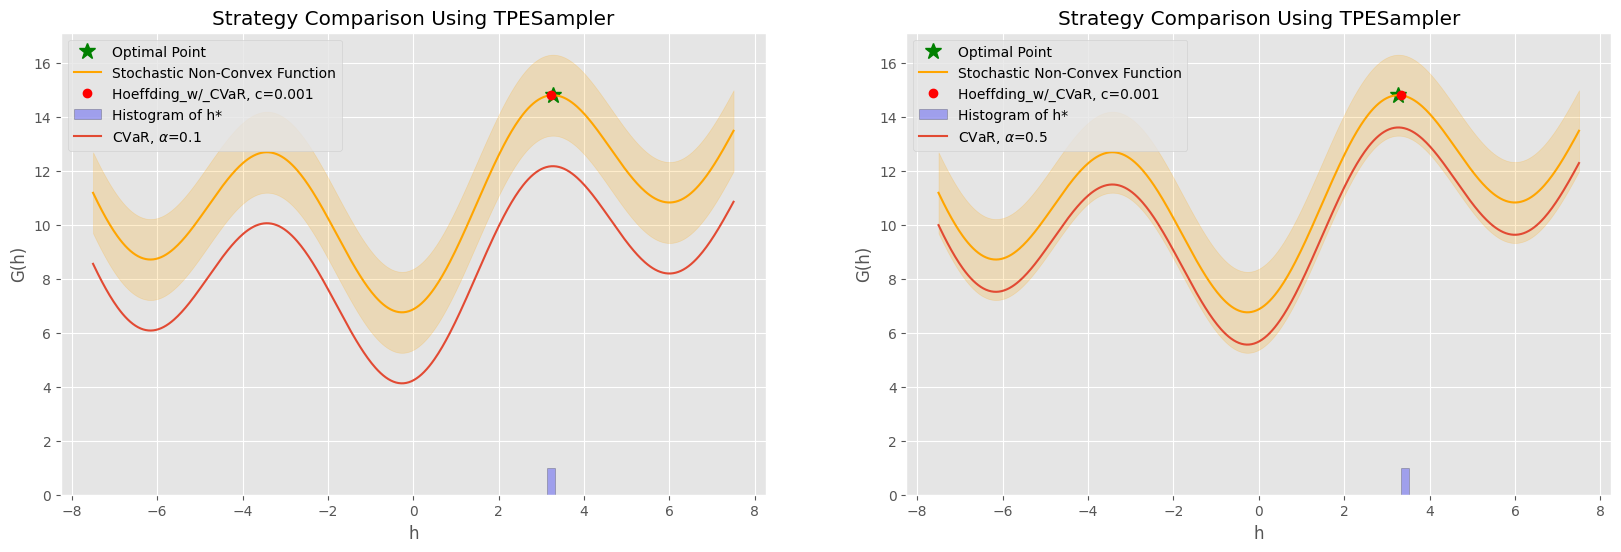

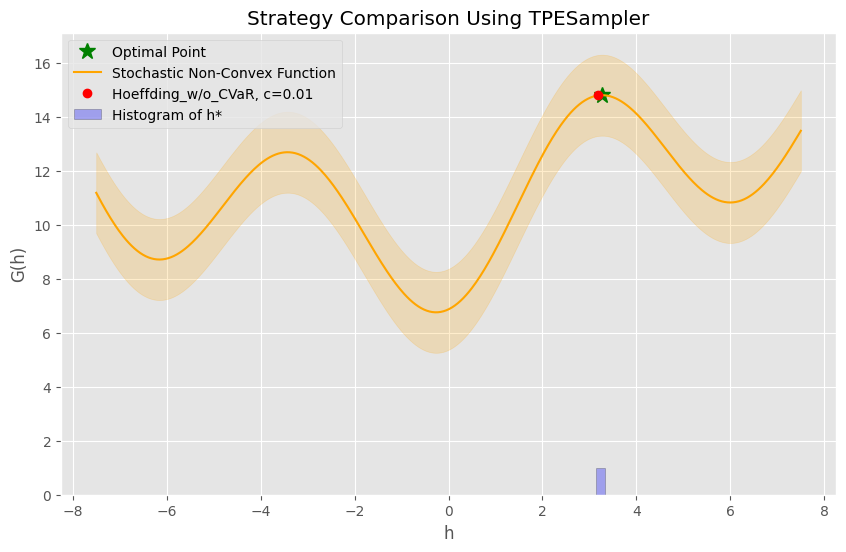

In [61]:
samplers = ["TPESampler"]
strategies = ["Hoeffding_w/_CVaR",
              "Hoeffding_w/o_CVaR"]
strategy_names = {"Hoeffding_w/_CVaR": "Hoeffding_w/_CVaR",
                  "Hoeffding_w/o_CVaR": "Hoeffding_w/o_CVaR"}
budgets = ['num_of_trials', 'num_of_eval']
bins = np.linspace(-7.5, 7.5, 80)
trial_to_describe = 350


In [ ]:
# visualize the results
for noise_level in noise_levels:
    for noise_function_mode in noise_function_modes:
        for sampler in samplers:
            idx = 0
            for strategy in strategies:      
                if strategy == "Hoeffding_w/_CVaR":
                        
                    # plt.scatter(x, noisy_function_values, alpha=0.5, color='orange')
                    # plot data points for each strategy
                    num_cols = len(alphas)  # Number of columns for subplots
                    fig, axs = plt.subplots(1, num_cols, figsize=(10 * num_cols, 6))
                    for idx, alpha in enumerate(alphas):
                        ax = axs[idx]
                        # Calculate the noisy function values
                        noisy_function_values = np.array([])
                        stds = np.array([]) 
                        for xi in x:
                                # append the noisy function values to the array
                                v, std = non_convex_noisy_function(xi, noise_function_mode, noise_level)
                                noisy_function_values = np.append(noisy_function_values, v)
                                stds = np.append(stds, std) 
                                
                        if noise_function_mode == 'h_e_h_v_l_e_h_v':
                                # plot the optimal point for x < 0 
                                ax.plot(x[np.argmax(original_function_values[:int(len(original_function_values)/2)])], 
                                        np.max(original_function_values[:int(len(original_function_values)/2)]), 
                                        '*', markersize=12, label="Desired Point", color='green')
                        else:
                                # plot the optimal point from original_function_values in green
                                ax.plot(x[np.argmax(original_function_values)], np.max(original_function_values), 
                                        '*', markersize=12, label="Optimal Point", color='green')
                        ax.plot(x, original_function_values, label='Stochastic Non-Convex Function', color='orange')
                        # plot std
                        ax.fill_between(x, original_function_values - stds, original_function_values + stds, alpha=0.2, color='orange')
                        ax.plot(hoeffding_df.loc[hoeffding_df['noise_function_mode'] == noise_function_mode].loc[hoeffding_df['num_of_trials'] == trial_to_describe].loc[hoeffding_df['Sampler'] == sampler].loc[hoeffding_df['Strategy'] == strategy].loc[hoeffding_df['alpha'] == alpha]['h'], 
                                hoeffding_df.loc[hoeffding_df['noise_function_mode'] == noise_function_mode].loc[hoeffding_df['num_of_trials'] == trial_to_describe].loc[hoeffding_df['Sampler'] == sampler].loc[hoeffding_df['Strategy'] == strategy].loc[hoeffding_df['alpha'] == alpha]['G'],
                                'o', label=strategy_names[strategy]+ f', c={percentage_cvar}', color='red')
                        ax.hist(hoeffding_df.loc[hoeffding_df['noise_function_mode'] == noise_function_mode].loc[hoeffding_df['num_of_trials'] == trial_to_describe].loc[hoeffding_df['Sampler'] == sampler].loc[hoeffding_df['Strategy'] == strategy].loc[hoeffding_df['alpha'] == alpha]['h'],
                                bins=bins, edgecolor='black', color='blue', alpha=0.3, label='Histogram of h*')

                        cvar = calculate_cvar(original_function_values, stds, alpha)
                        ax.plot(x, cvar, label=f'CVaR, ' + r'${\alpha} $' + f'={alpha}')
                        ax.set_xlabel('h')
                        ax.set_ylabel('G(h)')
                        ax.set_title('Strategy Comparison Using ' + sampler)
                        ax.legend()
                        ax.grid(True)
                    plt.show()
                    plt.close()
                elif strategy == "Hoeffding_w/o_CVaR":
                        plt.figure(figsize=(10, 6))
                    
                        # Calculate the noisy function values
                        noisy_function_values = np.array([])
                        stds = np.array([]) 
                        for xi in x:
                                # append the noisy function values to the array
                                v, std = non_convex_noisy_function(xi, noise_function_mode, noise_level)
                                noisy_function_values = np.append(noisy_function_values, v)
                                stds = np.append(stds, std) 
                                
                        if noise_function_mode == 'h_e_h_v_l_e_h_v':
                                # plot the optimal point for x < 0 
                                plt.plot(x[np.argmax(original_function_values[:int(len(original_function_values)/2)])], 
                                        np.max(original_function_values[:int(len(original_function_values)/2)]), 
                                        '*', markersize=12, label="Desired Point", color='green')
                        else:
                                # plot the optimal point from original_function_values in green
                                plt.plot(x[np.argmax(original_function_values)], np.max(original_function_values), 
                                        '*', markersize=12, label="Optimal Point", color='green')
                        plt.plot(x, original_function_values, label='Stochastic Non-Convex Function', color='orange')
                        # plot std
                        plt.fill_between(x, original_function_values - stds, original_function_values + stds, alpha=0.2, color='orange')
                        plt.plot(hoeffding_df.loc[hoeffding_df['noise_function_mode'] == noise_function_mode].loc[hoeffding_df['num_of_trials'] == trial_to_describe].loc[hoeffding_df['Sampler'] == sampler].loc[hoeffding_df['Strategy'] == strategy]['h'], 
                                hoeffding_df.loc[hoeffding_df['noise_function_mode'] == noise_function_mode].loc[hoeffding_df['num_of_trials'] == trial_to_describe].loc[hoeffding_df['Sampler'] == sampler].loc[hoeffding_df['Strategy'] == strategy]['G'],
                                'o', label=strategy_names[strategy]+ f', c={percentage_mean}', color='red')
                        plt.hist(hoeffding_df.loc[hoeffding_df['noise_function_mode'] == noise_function_mode].loc[hoeffding_df['num_of_trials'] == trial_to_describe].loc[hoeffding_df['Sampler'] == sampler].loc[hoeffding_df['Strategy'] == strategy]['h'],
                                bins=bins, edgecolor='black', color='blue', alpha=0.3, label='Histogram of h*')

                        plt.xlabel('h')
                        plt.ylabel('G(h)')
                        plt.title('Strategy Comparison Using ' + sampler)
                        plt.legend()
                        plt.grid(True)
                        plt.show()
                        plt.close()